<a href="https://colab.research.google.com/github/soutrik71/School_of_AI_ERA/blob/main/session7/Session7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
!pip install portalocker
!pip install torchview
!pip install torcheval
!pip install scikit-plot

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torchview import draw_graph
from pathlib import Path
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random
from torcheval.metrics import MulticlassAccuracy,BinaryAccuracy
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, OneCycleLR, ExponentialLR

## Helper Methods

In [4]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

In [5]:
# Set manual seed since nn.Parameter are randomly initialzied
set_seed(42)
# Set device cuda for GPU if it's available otherwise run on the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
batch_size = 1024
epochs = 15
lr = 1e-3

Random seed set as 42
cuda


In [6]:
def plot_loss_accuracy(train_loss, val_loss, train_acc, val_acc, labels, colors,
                       loss_legend_loc='upper center', acc_legend_loc='upper left', legend_font=5,
                       fig_size=(16, 10), sub_plot1=(1, 2, 1), sub_plot2=(1, 2, 2)):

    plt.rcParams["figure.figsize"] = fig_size
    plt.figure


    plt.subplot(sub_plot1[0], sub_plot1[1], sub_plot1[2])

    for i in range(len(train_loss)):
        x_train = range(len(train_loss[i]))
        x_val = range(len(val_loss[i]))

        min_train_loss = np.array(train_loss[i]).min()

        min_val_loss = np.array(val_loss[i]).min()

        plt.plot(x_train, train_loss[i], linestyle='-', color='tab:{}'.format(colors[i]),
                 label="TRAIN ({0:.4}): {1}".format(min_train_loss, labels[i]))
        plt.plot(x_val, val_loss[i], linestyle='--' , color='tab:{}'.format(colors[i]),
                 label="VALID ({0:.4}): {1}".format(min_val_loss, labels[i]))

    plt.xlabel('epoch no.')
    plt.ylabel('loss')
    plt.legend(loc=loss_legend_loc, prop={'size': legend_font})
    plt.title('Training and Validation Loss')

    plt.subplot(sub_plot2[0], sub_plot2[1], sub_plot2[2])

    for i in range(len(train_acc)):
        x_train = range(len(train_acc[i]))
        x_val = range(len(val_acc[i]))

        max_train_acc = np.array(train_acc[i]).max()

        max_val_acc = np.array(val_acc[i]).max()

        plt.plot(x_train, train_acc[i], linestyle='-', color='tab:{}'.format(colors[i]),
                 label="TRAIN ({0:.4}): {1}".format(max_train_acc, labels[i]))
        plt.plot(x_val, val_acc[i], linestyle='--' , color='tab:{}'.format(colors[i]),
                 label="VALID ({0:.4}): {1}".format(max_val_acc, labels[i]))

    plt.xlabel('epoch no.')
    plt.ylabel('accuracy')
    plt.legend(loc=acc_legend_loc, prop={'size': legend_font})
    plt.title('Training and Validation Accuracy')

    plt.show()

In [7]:
# decorator function to record time exp
from functools import wraps
import time

def timeit(func):
    @wraps(func)
    def timeit_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print(f'Function Took {total_time:.4f} seconds')
        return result
    return timeit_wrapper

## DataPrep

Basic train test dataprep without much changes

In [8]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))
                                ])


In [9]:
# downloading train and test data
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [10]:
#Dataloaders
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if device.type == 'cuda' else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


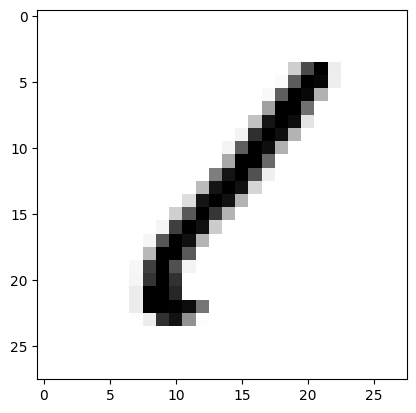

In [11]:
## Basic Data Statistics
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


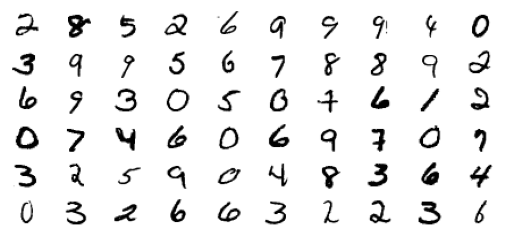

In [12]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(10, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## Basic Cnn Classification Model

A few layers of Convolution with Batch Normalization and transition layer with (1,1) consolidator layer and maxpooling between 2 sets of conviolutuion layers

In [23]:
class Mnist_Baseline(nn.Module):

  def __init__(self, in_channels, hidden_units, out_channels):
    super(Mnist_Baseline, self).__init__()

    # 3 sets of convolution blocks with batchnorm added
    self.conv1 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=in_channels, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #26,3
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        #set-2
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,  kernel_size=3, stride=1, padding=0), #24,5
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        #set-3
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,  kernel_size=3, stride=1, padding=0),#22,7
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
    )

    # transition block with 1,1 mixer and maxpool added after it ie condense and compress
    self.transition = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=1, stride=1, padding=0), #22,8
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2) #11,8
    )

    # 3 sets of convolution blocks with batchnorm added
    self.conv2 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #9,12
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        #set-2
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #7,16
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        #set-3
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=1, stride=1, padding=0), #7,20
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
    )

    self.classifier = nn.Sequential(nn.Conv2d(in_channels=hidden_units, out_channels=out_channels, kernel_size=7, stride=1, padding=0)) # 7*7 kernel as classifier


  def forward(self, x):
      x = self.conv1(x)
      x = self.transition(x)
      x = self.conv2(x)
      x = self.classifier(x)
      x = x.view(-1, 10)
      return F.log_softmax(x, dim=-1)

In [ ]:
# New Model Instance
baseline_model = Mnist_Baseline(in_channels=1,hidden_units=10,out_channels=10).to(device)
summary(baseline_model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]             910
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
            Conv2d-7           [-1, 10, 22, 22]             910
       BatchNorm2d-8           [-1, 10, 22, 22]              20
              ReLU-9           [-1, 10, 22, 22]               0
           Conv2d-10           [-1, 10, 22, 22]             110
      BatchNorm2d-11           [-1, 10, 22, 22]              20
             ReLU-12           [-1, 10, 22, 22]               0
        MaxPool2d-13           [-1, 10, 11, 11]               0
           Conv2d-14             [-1, 1

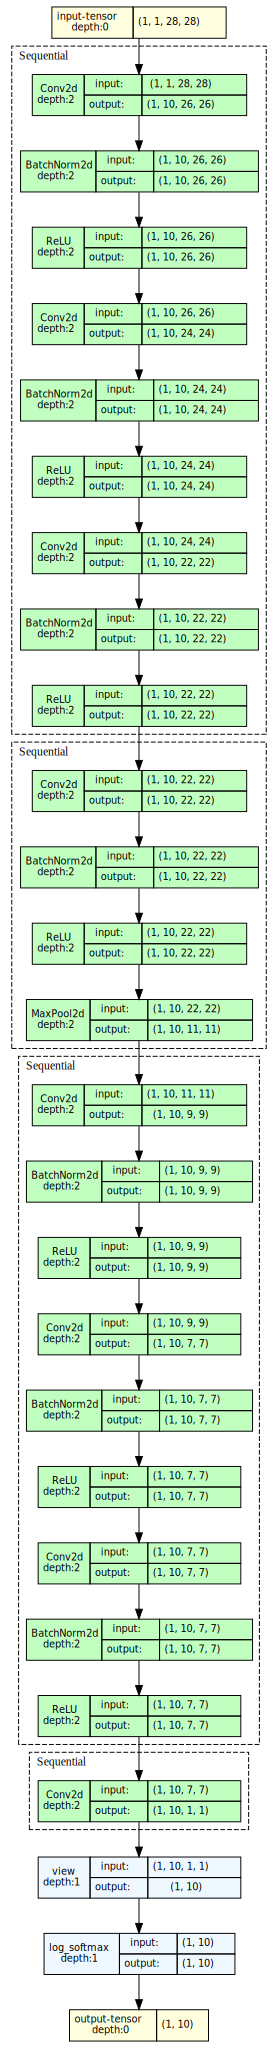

In [ ]:
# graphical representation of the model architecture
model_graph = draw_graph(baseline_model, input_size=(1,1, 28, 28), expand_nested=True)
model_graph.resize_graph(scale=10)
model_graph.visual_graph

In [13]:
# updated training module---
@timeit
def train_module(model:torch.nn.Module,
                 device:torch.device,
                 train_dataloader:torch.utils.data.DataLoader ,
                 optimizer:torch.optim.Optimizer,
                 criterion:torch.nn.Module,
                 metric,
                 train_losses:list,
                 train_metrics:list):

  # setting model to train mode
  model.train()
  pbar = tqdm(train_dataloader)

  # batch metrics
  train_loss = 0
  train_metric = 0
  processed_batch = 0

  for idx, (data,label) in enumerate(pbar):
    # setting up device
    data = data.to(device)
    label = label.to(device)

    # forward pass output
    preds = model(data)

    # calc loss
    loss = criterion(preds, label)
    train_loss += loss.item()
    # print(f"training loss for batch {idx} is {loss}")

    # backpropagation
    optimizer.zero_grad() # flush out  existing grads
    loss.backward() # back prop of weights wrt loss
    optimizer.step() # optimizer step -> minima

    # metric calc
    preds = torch.argmax(preds,dim=1)
    # print(f"preds:: {preds}")
    metric.update(preds,label)
    train_metric += metric.compute().detach().item()

    #updating batch count
    processed_batch += 1

    pbar.set_description(f"Avg Train Loss: {train_loss/processed_batch} Avg Train Metric: {train_metric/processed_batch}")

  # It's typically called after the epoch completes
  metric.reset()
  # updating epoch metrics
  train_losses.append(train_loss/processed_batch)
  train_metrics.append(train_metric/processed_batch)

  return train_losses, train_metrics


In [14]:
# updated testing modules---
@timeit
def test_module(model:torch.nn.Module,
                device:torch.device,
                test_dataloader:torch.utils.data.DataLoader,
                criterion:torch.nn.Module,
                metric,
                test_losses,
                test_metrics):
  # setting model to eval mode
  model.eval()
  pbar = tqdm(test_dataloader)

  # batch metrics
  test_loss = 0
  test_metric = 0
  processed_batch = 0

  with torch.inference_mode():
    for idx, (data,label) in enumerate(pbar):
      data , label = data.to(device), label.to(device)
      # predictions
      preds = model(data)
      # print(preds.shape)
      # print(label.shape)

      #loss calc
      loss = criterion(preds, label)
      test_loss += loss.item()

      # metric calc
      preds = torch.argmax(preds,dim=1)
      metric.update(preds,label)
      test_metric += metric.compute().detach().item()

      #updating batch count
      processed_batch += 1

      pbar.set_description(f"Avg Test Loss: {test_loss/processed_batch} Avg Test Metric: {test_metric/processed_batch}")

    # It's typically called after the epoch completes
    metric.reset()
    # updating epoch metrics
    test_losses.append(test_loss/processed_batch)
    test_metrics.append(test_metric/processed_batch)

  return test_losses, test_metrics

In [ ]:
# driver setup----
# optmizer
optimizer = optim.Adam(baseline_model.parameters(), lr=lr)
# loss
criterion = nn.CrossEntropyLoss()
# metric
metric = MulticlassAccuracy(device = device, num_classes=10)

In [ ]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(baseline_model, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(baseline_model, device, test_loader, criterion, metric, test_losses, test_metrics)

Epoch 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Avg Train Loss: 0.25226563037331423 Avg Train Metric: 0.8374954014222251: 100%|██████████| 469/469 [00:24<00:00, 19.01it/s]


Function Took 24.6727 seconds


Avg Test Loss: 0.0631502170492954 Avg Test Metric: 0.9813330573371694: 100%|██████████| 79/79 [00:03<00:00, 25.97it/s]


Function Took 3.0520 seconds
Epoch 1


Avg Train Loss: 0.05960463008670601 Avg Train Metric: 0.9808718161796456: 100%|██████████| 469/469 [00:25<00:00, 18.35it/s]


Function Took 25.5683 seconds


Avg Test Loss: 0.04718238328689638 Avg Test Metric: 0.9853686811048773: 100%|██████████| 79/79 [00:03<00:00, 26.23it/s]


Function Took 3.0188 seconds
Epoch 2


Avg Train Loss: 0.04406493315363982 Avg Train Metric: 0.9864187207557499: 100%|██████████| 469/469 [00:24<00:00, 19.45it/s]


Function Took 24.1215 seconds


Avg Test Loss: 0.036603952887692026 Avg Test Metric: 0.987190414078628: 100%|██████████| 79/79 [00:02<00:00, 31.95it/s]


Function Took 2.4812 seconds
Epoch 3


Avg Train Loss: 0.03485566936135451 Avg Train Metric: 0.9888042300494749: 100%|██████████| 469/469 [00:22<00:00, 20.53it/s]


Function Took 22.8600 seconds


Avg Test Loss: 0.033902585385603055 Avg Test Metric: 0.9892761956287336: 100%|██████████| 79/79 [00:04<00:00, 17.63it/s]


Function Took 4.5012 seconds
Epoch 4


Avg Train Loss: 0.031218855616215593 Avg Train Metric: 0.9906824205730007: 100%|██████████| 469/469 [00:25<00:00, 18.31it/s]


Function Took 25.6229 seconds


Avg Test Loss: 0.034285808783731886 Avg Test Metric: 0.9872727552546731: 100%|██████████| 79/79 [00:04<00:00, 19.53it/s]


Function Took 4.0600 seconds
Epoch 5


Avg Train Loss: 0.026723925668154475 Avg Train Metric: 0.9916642373050454: 100%|██████████| 469/469 [00:24<00:00, 19.22it/s]


Function Took 24.4216 seconds


Avg Test Loss: 0.036644137488041496 Avg Test Metric: 0.987217314635651: 100%|██████████| 79/79 [00:03<00:00, 22.69it/s]


Function Took 3.4924 seconds
Epoch 6


Avg Train Loss: 0.02303648055610515 Avg Train Metric: 0.9929554570458337: 100%|██████████| 469/469 [00:22<00:00, 21.14it/s]


Function Took 22.2000 seconds


Avg Test Loss: 0.03062257902767462 Avg Test Metric: 0.9907639569874052: 100%|██████████| 79/79 [00:04<00:00, 17.36it/s]


Function Took 4.5634 seconds
Epoch 7


Avg Train Loss: 0.021936112241859217 Avg Train Metric: 0.9936675752149716: 100%|██████████| 469/469 [00:20<00:00, 22.75it/s]


Function Took 20.6241 seconds


Avg Test Loss: 0.029773978392307682 Avg Test Metric: 0.989346778090996: 100%|██████████| 79/79 [00:02<00:00, 31.92it/s]


Function Took 2.4838 seconds
Epoch 8


Avg Train Loss: 0.018292112313687547 Avg Train Metric: 0.9950789027630902: 100%|██████████| 469/469 [00:21<00:00, 21.55it/s]


Function Took 21.7792 seconds


Avg Test Loss: 0.029045072176399393 Avg Test Metric: 0.9901328464097614: 100%|██████████| 79/79 [00:02<00:00, 29.79it/s]


Function Took 2.6633 seconds
Epoch 9


Avg Train Loss: 0.01712965969937538 Avg Train Metric: 0.9950331711311584: 100%|██████████| 469/469 [00:19<00:00, 23.99it/s]


Function Took 19.5615 seconds


Avg Test Loss: 0.02932003078336792 Avg Test Metric: 0.9913877497745466: 100%|██████████| 79/79 [00:03<00:00, 22.75it/s]


Function Took 3.4826 seconds
Epoch 10


Avg Train Loss: 0.014906195408411708 Avg Train Metric: 0.9957679132662857: 100%|██████████| 469/469 [00:18<00:00, 24.96it/s]


Function Took 18.7990 seconds


Avg Test Loss: 0.03545944239425508 Avg Test Metric: 0.9901246051245098: 100%|██████████| 79/79 [00:02<00:00, 31.60it/s]


Function Took 2.5108 seconds
Epoch 11


Avg Train Loss: 0.014372680423796665 Avg Train Metric: 0.995674336642853: 100%|██████████| 469/469 [00:21<00:00, 22.10it/s]


Function Took 21.2302 seconds


Avg Test Loss: 0.03111239872825674 Avg Test Metric: 0.9918796163571032: 100%|██████████| 79/79 [00:02<00:00, 32.65it/s]


Function Took 2.4271 seconds
Epoch 12


Avg Train Loss: 0.012871810631677092 Avg Train Metric: 0.9964633627232712: 100%|██████████| 469/469 [00:18<00:00, 24.73it/s]


Function Took 18.9732 seconds


Avg Test Loss: 0.04049307650214509 Avg Test Metric: 0.9882669720468642: 100%|██████████| 79/79 [00:02<00:00, 31.30it/s]


Function Took 2.5332 seconds
Epoch 13


Avg Train Loss: 0.013621717219058273 Avg Train Metric: 0.9961120523115211: 100%|██████████| 469/469 [00:20<00:00, 22.79it/s]


Function Took 20.5934 seconds


Avg Test Loss: 0.029968137443920337 Avg Test Metric: 0.9909309842918492: 100%|██████████| 79/79 [00:02<00:00, 32.67it/s]


Function Took 2.4262 seconds
Epoch 14


Avg Train Loss: 0.011541729587426127 Avg Train Metric: 0.9968405791691372: 100%|██████████| 469/469 [00:18<00:00, 25.06it/s]


Function Took 18.7231 seconds


Avg Test Loss: 0.030437108279571315 Avg Test Metric: 0.9918347657481327: 100%|██████████| 79/79 [00:03<00:00, 23.71it/s]

Function Took 3.3402 seconds


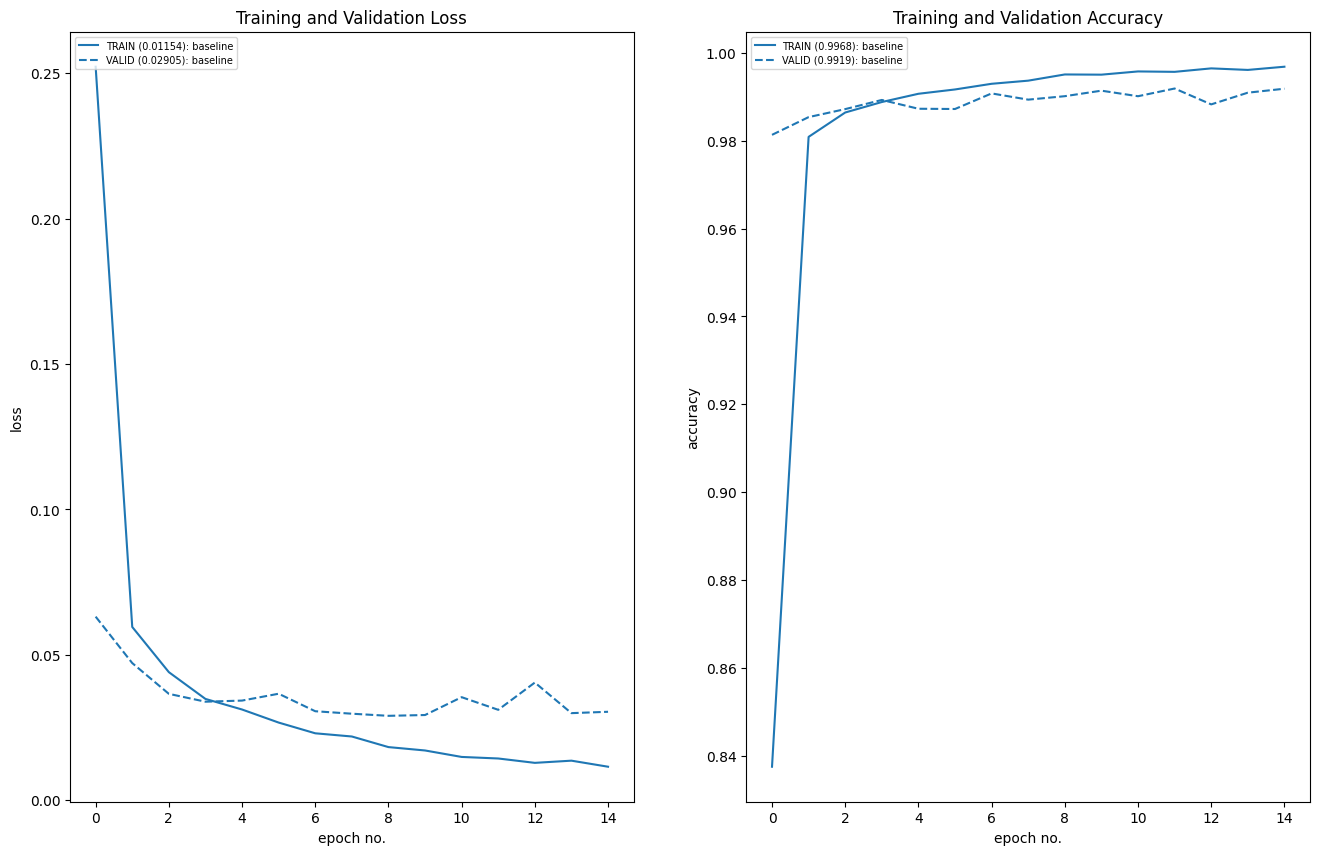

In [ ]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['baseline'],
                   colors=['blue'],
                   loss_legend_loc='upper left',
                   acc_legend_loc='upper left',
                   legend_font=7)

Target:

1. Setting up the basic premise for model development
2. Baselin model with 2 sets of convolution blocks and 1 transition block
3. Application of only Batch normalization after every Cnn layer
4. Transition block applied after RF==7

Results:\
Parameters: 9k\
Best Training Accuracy: 99.68\
Best Test Accuracy: 99.19

Analysis:
1. As a Baseline model extremely effective with consistent results ie Accuracy>99
2. At times have founds extremely faint hints of overfitting but within allowable threshold

## Baseline Model -2

Expansion of second conv block with a layer and double kernels

In [ ]:
class Mnist_Baseline2(nn.Module):

  def __init__(self, in_channels, hidden_units, out_channels):
    super(Mnist_Baseline2, self).__init__()

    # 3 sets of convolution blocks with batchnorm added
    self.conv1 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=in_channels, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #26,3
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        #set-2
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,  kernel_size=3, stride=1, padding=0), #24,5
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        #set-3
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,  kernel_size=3, stride=1, padding=0),#22,7
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
    )

    # transition block with 1,1 mixer and maxpool added after it ie condense and compress
    self.transition1 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=1, stride=1, padding=0), #22,8
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2) #11,8
    )

    # 3 sets of convolution blocks with batchnorm added
    self.conv2 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #9,12
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        #set-2
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #7,16
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),

        #set-3
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #5,20
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),

        #set-4
        nn.Conv2d(in_channels=hidden_units , out_channels=(hidden_units * 2), kernel_size=3, stride=1, padding=0), #3,24
        nn.BatchNorm2d(hidden_units*2),
        nn.ReLU(),
    )

    self.classifier = nn.Sequential(nn.Conv2d(in_channels=(hidden_units * 2), out_channels=out_channels, kernel_size=3, stride=1, padding=0)) # 3*3 kernel as classifier


  def forward(self, x):
      x = self.conv1(x)
      x = self.transition1(x)
      x = self.conv2(x)
      x = self.classifier(x)
      x = x.view(-1, 10)
      return F.log_softmax(x, dim=-1)

In [ ]:
# New Model Instance
baseline_model2 = Mnist_Baseline2(in_channels=1,hidden_units=10,out_channels=10).to(device)
summary(baseline_model2, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]             910
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
            Conv2d-7           [-1, 10, 22, 22]             910
       BatchNorm2d-8           [-1, 10, 22, 22]              20
              ReLU-9           [-1, 10, 22, 22]               0
           Conv2d-10           [-1, 10, 22, 22]             110
      BatchNorm2d-11           [-1, 10, 22, 22]              20
             ReLU-12           [-1, 10, 22, 22]               0
        MaxPool2d-13           [-1, 10, 11, 11]               0
           Conv2d-14             [-1, 1

In [ ]:
# driver setup----
# optmizer
optimizer = optim.Adam(baseline_model2.parameters(), lr=lr)
# loss
criterion = nn.CrossEntropyLoss()
# metric
metric = MulticlassAccuracy(device = device, num_classes=10)

In [ ]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(baseline_model2, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(baseline_model2, device, test_loader, criterion, metric, test_losses, test_metrics)

Epoch 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Avg Train Loss: 0.3283296484293651 Avg Train Metric: 0.7863691413580481: 100%|██████████| 469/469 [00:21<00:00, 21.94it/s]


Function Took 21.3825 seconds


Avg Test Loss: 0.06487018798914136 Avg Test Metric: 0.9788070668148089: 100%|██████████| 79/79 [00:02<00:00, 28.19it/s]


Function Took 2.8086 seconds
Epoch 1


Avg Train Loss: 0.059875789214608705 Avg Train Metric: 0.9817220249664046: 100%|██████████| 469/469 [00:24<00:00, 19.46it/s]


Function Took 24.1044 seconds


Avg Test Loss: 0.046841448396915876 Avg Test Metric: 0.9843425878995582: 100%|██████████| 79/79 [00:02<00:00, 27.36it/s]


Function Took 2.8983 seconds
Epoch 2


Avg Train Loss: 0.04499429662519299 Avg Train Metric: 0.9860925643937166: 100%|██████████| 469/469 [00:20<00:00, 22.59it/s]


Function Took 20.7662 seconds


Avg Test Loss: 0.034452831752810484 Avg Test Metric: 0.9899343697330619: 100%|██████████| 79/79 [00:03<00:00, 22.73it/s]


Function Took 3.4814 seconds
Epoch 3


Avg Train Loss: 0.037459129610085 Avg Train Metric: 0.9885944125494723: 100%|██████████| 469/469 [00:22<00:00, 20.44it/s]


Function Took 22.9551 seconds


Avg Test Loss: 0.035130200689493477 Avg Test Metric: 0.9882037865964672: 100%|██████████| 79/79 [00:03<00:00, 26.29it/s]


Function Took 3.0141 seconds
Epoch 4


Avg Train Loss: 0.03245497872131561 Avg Train Metric: 0.9889875194157111: 100%|██████████| 469/469 [00:20<00:00, 23.22it/s]


Function Took 20.2053 seconds


Avg Test Loss: 0.03109943007908856 Avg Test Metric: 0.9885343456570106: 100%|██████████| 79/79 [00:02<00:00, 32.52it/s]


Function Took 2.4382 seconds
Epoch 5


Avg Train Loss: 0.030803215677297907 Avg Train Metric: 0.9914320172277341: 100%|██████████| 469/469 [00:20<00:00, 22.64it/s]


Function Took 20.7271 seconds


Avg Test Loss: 0.027918703915975705 Avg Test Metric: 0.9896007353746439: 100%|██████████| 79/79 [00:02<00:00, 27.61it/s]


Function Took 2.8696 seconds
Epoch 6


Avg Train Loss: 0.027278921692503063 Avg Train Metric: 0.9923291942203986: 100%|██████████| 469/469 [00:19<00:00, 24.11it/s]


Function Took 19.4569 seconds


Avg Test Loss: 0.033773146160064806 Avg Test Metric: 0.99262250450593: 100%|██████████| 79/79 [00:02<00:00, 31.29it/s]


Function Took 2.5341 seconds
Epoch 7


Avg Train Loss: 0.024291769234659172 Avg Train Metric: 0.9925521678253532: 100%|██████████| 469/469 [00:20<00:00, 22.38it/s]


Function Took 20.9655 seconds


Avg Test Loss: 0.030015894872006735 Avg Test Metric: 0.9898539004446585: 100%|██████████| 79/79 [00:02<00:00, 27.59it/s]


Function Took 2.8762 seconds
Epoch 8


Avg Train Loss: 0.023082725076711795 Avg Train Metric: 0.9922851005088545: 100%|██████████| 469/469 [00:19<00:00, 23.91it/s]


Function Took 19.6255 seconds


Avg Test Loss: 0.02627077141958672 Avg Test Metric: 0.9894956372961213: 100%|██████████| 79/79 [00:03<00:00, 23.04it/s]


Function Took 3.4358 seconds
Epoch 9


Avg Train Loss: 0.02079704593902311 Avg Train Metric: 0.9937374720187075: 100%|██████████| 469/469 [00:19<00:00, 24.02it/s]


Function Took 19.5368 seconds


Avg Test Loss: 0.02747641440592942 Avg Test Metric: 0.9930141673812384: 100%|██████████| 79/79 [00:02<00:00, 32.45it/s]


Function Took 2.4426 seconds
Epoch 10


Avg Train Loss: 0.01910403080315375 Avg Train Metric: 0.994485310018698: 100%|██████████| 469/469 [00:21<00:00, 22.21it/s]


Function Took 21.1255 seconds


Avg Test Loss: 0.026622549241207556 Avg Test Metric: 0.9915651294249522: 100%|██████████| 79/79 [00:02<00:00, 32.33it/s]


Function Took 2.4507 seconds
Epoch 11


Avg Train Loss: 0.018256911759335262 Avg Train Metric: 0.9946465931975765: 100%|██████████| 469/469 [00:21<00:00, 22.23it/s]


Function Took 21.1055 seconds


Avg Test Loss: 0.031356753401246065 Avg Test Metric: 0.9903580350211904: 100%|██████████| 79/79 [00:02<00:00, 31.04it/s]


Function Took 2.5551 seconds
Epoch 12


Avg Train Loss: 0.01785831885866082 Avg Train Metric: 0.99491983321684: 100%|██████████| 469/469 [00:20<00:00, 22.63it/s]


Function Took 20.7297 seconds


Avg Test Loss: 0.028269393965631395 Avg Test Metric: 0.9886210100560249: 100%|██████████| 79/79 [00:02<00:00, 31.19it/s]


Function Took 2.5438 seconds
Epoch 13


Avg Train Loss: 0.015796726548806952 Avg Train Metric: 0.9957829567669297: 100%|██████████| 469/469 [00:19<00:00, 23.79it/s]


Function Took 19.7278 seconds


Avg Test Loss: 0.030337665843426637 Avg Test Metric: 0.9897764657117143: 100%|██████████| 79/79 [00:03<00:00, 22.41it/s]


Function Took 3.5317 seconds
Epoch 14


Avg Train Loss: 0.0151609531474679 Avg Train Metric: 0.9947716888588375: 100%|██████████| 469/469 [00:19<00:00, 24.10it/s]


Function Took 19.4665 seconds


Avg Test Loss: 0.03003818280714906 Avg Test Metric: 0.986554425728472: 100%|██████████| 79/79 [00:02<00:00, 28.11it/s]

Function Took 2.8230 seconds


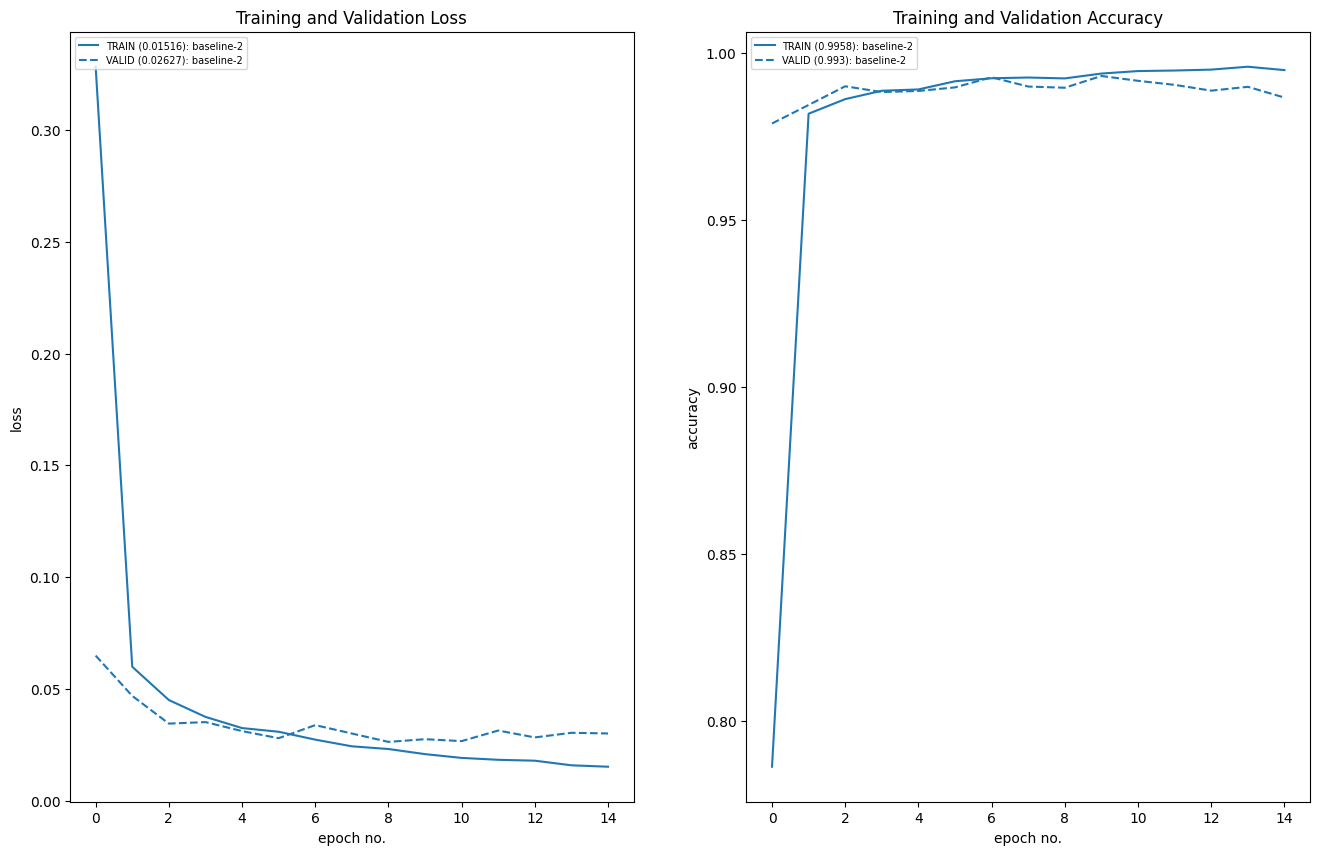

In [ ]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['baseline-2'],
                   colors=['blue'],
                   loss_legend_loc='upper left',
                   acc_legend_loc='upper left',
                   legend_font=7)

Analysis:
1. Increasing channels/kernels in any layers leads to more overfitting and increased gap with increasing epochs

In [ ]:
class Mnist_Baseline3(nn.Module):

  def __init__(self, in_channels, hidden_units, out_channels):
    super(Mnist_Baseline3, self).__init__()

    # 3 sets of convolution blocks with batchnorm added
    self.conv1 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=in_channels, out_channels=hidden_units*2, kernel_size=3, stride=1, padding=0), #26,3
        nn.BatchNorm2d(hidden_units*2),
        nn.ReLU(),
        #set-2
        nn.Conv2d(in_channels=hidden_units*2, out_channels=hidden_units,  kernel_size=3, stride=1, padding=0), #24,5
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        #set-3
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,  kernel_size=3, stride=1, padding=0),#22,7
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
    )

    # transition block with 1,1 mixer and maxpool added after it ie condense and compress
    self.transition1 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=1, stride=1, padding=0), #22,8
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2) #11,8
    )

    # 3 sets of convolution blocks with batchnorm added
    self.conv2 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units*2, kernel_size=3, stride=1, padding=0), #9,12
        nn.BatchNorm2d(hidden_units*2),
        nn.ReLU(),
        #set-2
        nn.Conv2d(in_channels=hidden_units*2, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #7,16
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),

        #set-3
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #5,20
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),

        #set-4
        nn.Conv2d(in_channels=hidden_units , out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #3,24
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
    )

    self.classifier = nn.Sequential(nn.Conv2d(in_channels=hidden_units, out_channels=out_channels, kernel_size=3, stride=1, padding=0)) # 3*3 kernel as classifier


  def forward(self, x):
      x = self.conv1(x)
      x = self.transition1(x)
      x = self.conv2(x)
      x = self.classifier(x)
      x = x.view(-1, 10)
      return F.log_softmax(x, dim=-1)

In [ ]:
# New Model Instance
baseline_model3 = Mnist_Baseline3(in_channels=1,hidden_units=10,out_channels=10).to(device)
summary(baseline_model3, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 26, 26]             200
       BatchNorm2d-2           [-1, 20, 26, 26]              40
              ReLU-3           [-1, 20, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]           1,810
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
            Conv2d-7           [-1, 10, 22, 22]             910
       BatchNorm2d-8           [-1, 10, 22, 22]              20
              ReLU-9           [-1, 10, 22, 22]               0
           Conv2d-10           [-1, 10, 22, 22]             110
      BatchNorm2d-11           [-1, 10, 22, 22]              20
             ReLU-12           [-1, 10, 22, 22]               0
        MaxPool2d-13           [-1, 10, 11, 11]               0
           Conv2d-14             [-1, 2

In [ ]:
# driver setup----
# optmizer
optimizer = optim.Adam(baseline_model3.parameters(), lr=lr)
# loss
criterion = nn.CrossEntropyLoss()
# metric
metric = MulticlassAccuracy(device = device, num_classes=10)

In [ ]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(baseline_model3, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(baseline_model3, device, test_loader, criterion, metric, test_losses, test_metrics)

Epoch 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Avg Train Loss: 0.4155198448994902 Avg Train Metric: 0.7544693607193574: 100%|██████████| 469/469 [00:21<00:00, 21.95it/s]


Function Took 21.3755 seconds


Avg Test Loss: 0.0938894151698185 Avg Test Metric: 0.9731635541855534: 100%|██████████| 79/79 [00:02<00:00, 31.60it/s]


Function Took 2.5080 seconds
Epoch 1


Avg Train Loss: 0.07352545297444502 Avg Train Metric: 0.9770787974664652: 100%|██████████| 469/469 [00:20<00:00, 22.70it/s]


Function Took 20.6716 seconds


Avg Test Loss: 0.05135074145561438 Avg Test Metric: 0.9853009053423435: 100%|██████████| 79/79 [00:02<00:00, 31.22it/s]


Function Took 2.5399 seconds
Epoch 2


Avg Train Loss: 0.05144185034919586 Avg Train Metric: 0.9837824547214549: 100%|██████████| 469/469 [00:20<00:00, 22.56it/s]


Function Took 20.7985 seconds


Avg Test Loss: 0.049110479782559446 Avg Test Metric: 0.9852526331249671: 100%|██████████| 79/79 [00:03<00:00, 24.34it/s]


Function Took 3.2540 seconds
Epoch 3


Avg Train Loss: 0.04300080965271096 Avg Train Metric: 0.9876549513355247: 100%|██████████| 469/469 [00:20<00:00, 23.39it/s]


Function Took 20.0628 seconds


Avg Test Loss: 0.04062618891696764 Avg Test Metric: 0.9876969849007039: 100%|██████████| 79/79 [00:02<00:00, 31.06it/s]


Function Took 2.5521 seconds
Epoch 4


Avg Train Loss: 0.03554780203114345 Avg Train Metric: 0.9890652827616694: 100%|██████████| 469/469 [00:21<00:00, 22.18it/s]


Function Took 21.1583 seconds


Avg Test Loss: 0.03627598661740747 Avg Test Metric: 0.9869487987288946: 100%|██████████| 79/79 [00:02<00:00, 30.36it/s]


Function Took 2.6110 seconds
Epoch 5


Avg Train Loss: 0.03227238002062432 Avg Train Metric: 0.9899777276937896: 100%|██████████| 469/469 [00:19<00:00, 23.98it/s]


Function Took 19.5646 seconds


Avg Test Loss: 0.037601126125082374 Avg Test Metric: 0.9887290770494486: 100%|██████████| 79/79 [00:02<00:00, 30.69it/s]


Function Took 2.5825 seconds
Epoch 6


Avg Train Loss: 0.02951240263455339 Avg Train Metric: 0.9920284683262107: 100%|██████████| 469/469 [00:20<00:00, 22.63it/s]


Function Took 20.7272 seconds


Avg Test Loss: 0.0387147956150525 Avg Test Metric: 0.9874381091021285: 100%|██████████| 79/79 [00:02<00:00, 31.87it/s]


Function Took 2.4879 seconds
Epoch 7


Avg Train Loss: 0.02744695156944721 Avg Train Metric: 0.9920985055630649: 100%|██████████| 469/469 [00:20<00:00, 23.37it/s]


Function Took 20.0815 seconds


Avg Test Loss: 0.03214274429645436 Avg Test Metric: 0.9892149099820777: 100%|██████████| 79/79 [00:03<00:00, 24.22it/s]


Function Took 3.2717 seconds
Epoch 8


Avg Train Loss: 0.024587248801253736 Avg Train Metric: 0.99321925767195: 100%|██████████| 469/469 [00:19<00:00, 24.02it/s]


Function Took 19.5322 seconds


Avg Test Loss: 0.03313845098998598 Avg Test Metric: 0.9897501853447926: 100%|██████████| 79/79 [00:02<00:00, 31.23it/s]


Function Took 2.5388 seconds
Epoch 9


Avg Train Loss: 0.022026948694354183 Avg Train Metric: 0.9939944394615922: 100%|██████████| 469/469 [00:21<00:00, 21.99it/s]


Function Took 21.3367 seconds


Avg Test Loss: 0.03300970912427653 Avg Test Metric: 0.9891893327990665: 100%|██████████| 79/79 [00:02<00:00, 32.04it/s]


Function Took 2.4741 seconds
Epoch 10


Avg Train Loss: 0.0223898977003515 Avg Train Metric: 0.9931400178083732: 100%|██████████| 469/469 [00:21<00:00, 21.51it/s]


Function Took 21.8102 seconds


Avg Test Loss: 0.03396070055933256 Avg Test Metric: 0.9904901800276358: 100%|██████████| 79/79 [00:02<00:00, 27.06it/s]


Function Took 2.9256 seconds
Epoch 11


Avg Train Loss: 0.020718405586429067 Avg Train Metric: 0.9937437610077197: 100%|██████████| 469/469 [00:19<00:00, 23.76it/s]


Function Took 19.7472 seconds


Avg Test Loss: 0.02971054510732146 Avg Test Metric: 0.9901982500583311: 100%|██████████| 79/79 [00:02<00:00, 32.22it/s]


Function Took 2.4638 seconds
Epoch 12


Avg Train Loss: 0.018354193549412093 Avg Train Metric: 0.9943607553744367: 100%|██████████| 469/469 [00:20<00:00, 22.34it/s]


Function Took 21.0018 seconds


Avg Test Loss: 0.03201844639067842 Avg Test Metric: 0.9881280200390876: 100%|██████████| 79/79 [00:02<00:00, 31.54it/s]


Function Took 2.5118 seconds
Epoch 13


Avg Train Loss: 0.01848863724987509 Avg Train Metric: 0.9943460796687649: 100%|██████████| 469/469 [00:19<00:00, 23.72it/s]


Function Took 19.7811 seconds


Avg Test Loss: 0.03789248480461538 Avg Test Metric: 0.9876126865797406: 100%|██████████| 79/79 [00:03<00:00, 22.21it/s]


Function Took 3.5661 seconds
Epoch 14


Avg Train Loss: 0.015811996578898178 Avg Train Metric: 0.9952849865213894: 100%|██████████| 469/469 [00:19<00:00, 23.59it/s]


Function Took 19.8961 seconds


Avg Test Loss: 0.027837983525617498 Avg Test Metric: 0.9909027580973468: 100%|██████████| 79/79 [00:02<00:00, 32.01it/s]

Function Took 2.4746 seconds


Analysis:
1. Increasing channels/kernels in any layers leads to more overfitting and increased gap with increasing epochs

## Application of Dropouts on Baseline and Baseline2

First we apply dropout at the end of each convolution block

In [ ]:
class Mnist_Baseline_Dropout(nn.Module):

  def __init__(self, in_channels, hidden_units, out_channels):
    super(Mnist_Baseline_Dropout, self).__init__()

    # 3 sets of convolution blocks with batchnorm added
    self.conv1 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=in_channels, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #26,3
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        #set-2
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,  kernel_size=3, stride=1, padding=0), #24,5
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        #set-3
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,  kernel_size=3, stride=1, padding=0),#22,7
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
    )

    # transition block with 1,1 mixer and maxpool added after it ie condense and compress
    self.transition = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=1, stride=1, padding=0), #22,8
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2) #11,8
    )

    # 3 sets of convolution blocks with batchnorm added
    self.conv2 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #9,12
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        #set-2
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #7,16
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        #set-3
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=1, stride=1, padding=0), #7,20
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
    )

    self.classifier = nn.Sequential(nn.Conv2d(in_channels=hidden_units, out_channels=out_channels, kernel_size=7, stride=1, padding=0)) # 7*7 kernel as classifier
    self.dropout = nn.Dropout(p=0.1)


  def forward(self, x):
      x = self.conv1(x)
      x = self.dropout(x)
      x = self.transition(x)
      x = self.conv2(x)
      x = self.dropout(x)
      x = self.classifier(x)
      x = x.view(-1, 10)
      return F.log_softmax(x, dim=-1)

In [ ]:
# New Model Instance
baseline_model_dpo = Mnist_Baseline_Dropout(in_channels=1,hidden_units=10,out_channels=10).to(device)
summary(baseline_model_dpo, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]             910
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
            Conv2d-7           [-1, 10, 22, 22]             910
       BatchNorm2d-8           [-1, 10, 22, 22]              20
              ReLU-9           [-1, 10, 22, 22]               0
          Dropout-10           [-1, 10, 22, 22]               0
           Conv2d-11           [-1, 10, 22, 22]             110
      BatchNorm2d-12           [-1, 10, 22, 22]              20
             ReLU-13           [-1, 10, 22, 22]               0
        MaxPool2d-14           [-1, 10,

In [ ]:
# driver setup----
# optmizer
optimizer = optim.Adam(baseline_model_dpo.parameters(), lr=lr)
# loss
criterion = nn.CrossEntropyLoss()
# metric
metric = MulticlassAccuracy(device = device, num_classes=10)

In [ ]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(baseline_model_dpo, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(baseline_model_dpo, device, test_loader, criterion, metric, test_losses, test_metrics)

Epoch 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Avg Train Loss: 0.269524307151053 Avg Train Metric: 0.8359714136131282: 100%|██████████| 469/469 [00:25<00:00, 18.05it/s]


Function Took 26.0026 seconds


Avg Test Loss: 0.0780305069741569 Avg Test Metric: 0.9760886574093299: 100%|██████████| 79/79 [00:02<00:00, 30.53it/s]


Function Took 2.5966 seconds
Epoch 1


Avg Train Loss: 0.06132010989157217 Avg Train Metric: 0.9813533316034753: 100%|██████████| 469/469 [00:21<00:00, 21.41it/s]


Function Took 21.9186 seconds


Avg Test Loss: 0.045616030905254276 Avg Test Metric: 0.9852889414075054: 100%|██████████| 79/79 [00:02<00:00, 30.51it/s]


Function Took 2.5997 seconds
Epoch 2


Avg Train Loss: 0.04638979758825034 Avg Train Metric: 0.9866594940360421: 100%|██████████| 469/469 [00:20<00:00, 22.73it/s]


Function Took 20.6433 seconds


Avg Test Loss: 0.04225397122953134 Avg Test Metric: 0.9837486404406873: 100%|██████████| 79/79 [00:03<00:00, 25.79it/s]


Function Took 3.0709 seconds
Epoch 3


Avg Train Loss: 0.040311691557257764 Avg Train Metric: 0.9880202366853319: 100%|██████████| 469/469 [00:21<00:00, 21.86it/s]


Function Took 21.4581 seconds


Avg Test Loss: 0.035131633063613235 Avg Test Metric: 0.9872564431987231: 100%|██████████| 79/79 [00:04<00:00, 19.69it/s]


Function Took 4.0291 seconds
Epoch 4


Avg Train Loss: 0.035679960489841 Avg Train Metric: 0.9895433645004402: 100%|██████████| 469/469 [00:22<00:00, 20.96it/s]


Function Took 22.3792 seconds


Avg Test Loss: 0.03425536166487521 Avg Test Metric: 0.988924992235401: 100%|██████████| 79/79 [00:02<00:00, 30.27it/s]


Function Took 2.6204 seconds
Epoch 5


Avg Train Loss: 0.03210507403028561 Avg Train Metric: 0.9903505534759717: 100%|██████████| 469/469 [00:20<00:00, 22.80it/s]


Function Took 20.5759 seconds


Avg Test Loss: 0.03384394418224221 Avg Test Metric: 0.9880884138843681: 100%|██████████| 79/79 [00:03<00:00, 20.74it/s]


Function Took 3.8213 seconds
Epoch 6


Avg Train Loss: 0.029522600735642952 Avg Train Metric: 0.9904822028522045: 100%|██████████| 469/469 [00:20<00:00, 22.80it/s]


Function Took 20.5821 seconds


Avg Test Loss: 0.03342965852964339 Avg Test Metric: 0.9889501257787777: 100%|██████████| 79/79 [00:02<00:00, 30.59it/s]


Function Took 2.5897 seconds
Epoch 7


Avg Train Loss: 0.027044954474147623 Avg Train Metric: 0.9917170302445955: 100%|██████████| 469/469 [00:22<00:00, 21.16it/s]


Function Took 22.1708 seconds


Avg Test Loss: 0.036232226271082094 Avg Test Metric: 0.9897633715520932: 100%|██████████| 79/79 [00:02<00:00, 30.32it/s]


Function Took 2.6140 seconds
Epoch 8


Avg Train Loss: 0.026244752802826496 Avg Train Metric: 0.9916425769262985: 100%|██████████| 469/469 [00:22<00:00, 20.56it/s]


Function Took 22.8218 seconds


Avg Test Loss: 0.03279738803099416 Avg Test Metric: 0.9901005897340895: 100%|██████████| 79/79 [00:03<00:00, 25.32it/s]


Function Took 3.1270 seconds
Epoch 9


Avg Train Loss: 0.024492709184569843 Avg Train Metric: 0.9920412736660891: 100%|██████████| 469/469 [00:20<00:00, 22.92it/s]


Function Took 20.4727 seconds


Avg Test Loss: 0.035153250133359355 Avg Test Metric: 0.9889936922471735: 100%|██████████| 79/79 [00:02<00:00, 29.86it/s]


Function Took 2.6542 seconds
Epoch 10


Avg Train Loss: 0.02318122346368211 Avg Train Metric: 0.9924606562677477: 100%|██████████| 469/469 [00:21<00:00, 21.47it/s]


Function Took 21.8542 seconds


Avg Test Loss: 0.035085843248245645 Avg Test Metric: 0.9909160853941229: 100%|██████████| 79/79 [00:02<00:00, 31.04it/s]


Function Took 2.5535 seconds
Epoch 11


Avg Train Loss: 0.02135542443661051 Avg Train Metric: 0.9928272339835096: 100%|██████████| 469/469 [00:21<00:00, 22.19it/s]


Function Took 21.1504 seconds


Avg Test Loss: 0.03214035578266588 Avg Test Metric: 0.9906324812128574: 100%|██████████| 79/79 [00:03<00:00, 25.62it/s]


Function Took 3.0887 seconds
Epoch 12


Avg Train Loss: 0.019940015134384988 Avg Train Metric: 0.9945390868796977: 100%|██████████| 469/469 [00:20<00:00, 23.03it/s]


Function Took 20.3800 seconds


Avg Test Loss: 0.031097138875246615 Avg Test Metric: 0.9890843660016603: 100%|██████████| 79/79 [00:02<00:00, 30.37it/s]


Function Took 2.6093 seconds
Epoch 13


Avg Train Loss: 0.020716194567498444 Avg Train Metric: 0.9941522524809279: 100%|██████████| 469/469 [00:21<00:00, 21.66it/s]


Function Took 21.6585 seconds


Avg Test Loss: 0.030469413733999893 Avg Test Metric: 0.9902538664733307: 100%|██████████| 79/79 [00:02<00:00, 30.71it/s]


Function Took 2.5825 seconds
Epoch 14


Avg Train Loss: 0.018768252922966182 Avg Train Metric: 0.9945270575440006: 100%|██████████| 469/469 [00:21<00:00, 22.17it/s]


Function Took 21.1638 seconds


Avg Test Loss: 0.028011866478998025 Avg Test Metric: 0.9908178426042388: 100%|██████████| 79/79 [00:03<00:00, 25.09it/s]

Function Took 3.1556 seconds


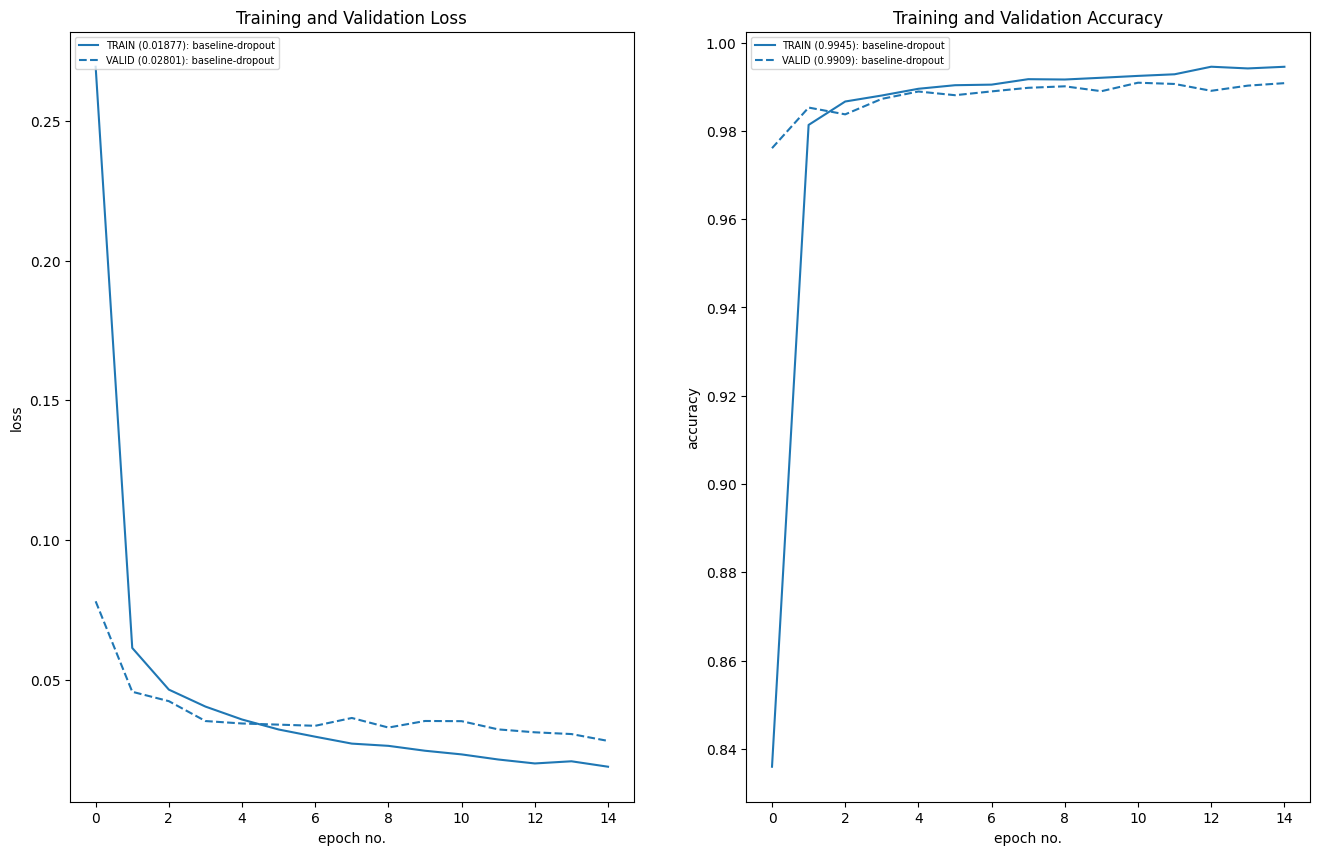

In [ ]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['baseline-dropout'],
                   colors=['blue'],
                   loss_legend_loc='upper left',
                   acc_legend_loc='upper left',
                   legend_font=7)

In [ ]:
class Mnist_Baseline2_Dropout(nn.Module):

  def __init__(self, in_channels, hidden_units, out_channels):
    super(Mnist_Baseline2_Dropout, self).__init__()

    # 3 sets of convolution blocks with batchnorm added
    self.conv1 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=in_channels, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #26,3
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        #set-2
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,  kernel_size=3, stride=1, padding=0), #24,5
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        #set-3
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,  kernel_size=3, stride=1, padding=0),#22,7
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
    )

    # transition block with 1,1 mixer and maxpool added after it ie condense and compress
    self.transition1 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=1, stride=1, padding=0), #22,8
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2) #11,8
    )

    # 3 sets of convolution blocks with batchnorm added
    self.conv2 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #9,12
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        #set-2
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #7,16
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),

        #set-3
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #5,20
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),

        #set-4
        nn.Conv2d(in_channels=hidden_units , out_channels=(hidden_units * 2), kernel_size=3, stride=1, padding=0), #3,24
        nn.BatchNorm2d(hidden_units*2),
        nn.ReLU(),
    )

    self.classifier = nn.Sequential(nn.Conv2d(in_channels=(hidden_units * 2), out_channels=out_channels, kernel_size=3, stride=1, padding=0)) # 3*3 kernel as classifier
    self.dropout = nn.Dropout(p=0.1)


  def forward(self, x):
      x = self.conv1(x)
      x = self.dropout(x)
      x = self.transition1(x)
      x = self.conv2(x)
      x = self.dropout(x)
      x = self.classifier(x)
      x = x.view(-1, 10)
      return F.log_softmax(x, dim=-1)

In [ ]:
# New Model Instance
baseline_model_dp2 = Mnist_Baseline2_Dropout(in_channels=1,hidden_units=10,out_channels=10).to(device)
summary(baseline_model_dp2, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]             910
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
            Conv2d-7           [-1, 10, 22, 22]             910
       BatchNorm2d-8           [-1, 10, 22, 22]              20
              ReLU-9           [-1, 10, 22, 22]               0
          Dropout-10           [-1, 10, 22, 22]               0
           Conv2d-11           [-1, 10, 22, 22]             110
      BatchNorm2d-12           [-1, 10, 22, 22]              20
             ReLU-13           [-1, 10, 22, 22]               0
        MaxPool2d-14           [-1, 10,

In [ ]:
# driver setup----
# optmizer
optimizer = optim.Adam(baseline_model_dp2.parameters(), lr=lr)
# loss
criterion = nn.CrossEntropyLoss()
# metric
metric = MulticlassAccuracy(device = device, num_classes=10)

In [ ]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(baseline_model_dp2, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(baseline_model_dp2, device, test_loader, criterion, metric, test_losses, test_metrics)

Epoch 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Avg Train Loss: 0.3477857205500481 Avg Train Metric: 0.7680354004761557: 100%|██████████| 469/469 [00:21<00:00, 21.79it/s]


Function Took 21.5365 seconds


Avg Test Loss: 0.0627177710633112 Avg Test Metric: 0.9819189838216275: 100%|██████████| 79/79 [00:03<00:00, 25.49it/s]


Function Took 3.1117 seconds
Epoch 1


Avg Train Loss: 0.06592945555951804 Avg Train Metric: 0.9789886271267303: 100%|██████████| 469/469 [00:20<00:00, 23.05it/s]


Function Took 20.3486 seconds


Avg Test Loss: 0.05179150474458179 Avg Test Metric: 0.9844076625908478: 100%|██████████| 79/79 [00:02<00:00, 28.56it/s]


Function Took 2.7787 seconds
Epoch 2


Avg Train Loss: 0.051219871505967844 Avg Train Metric: 0.984573396792544: 100%|██████████| 469/469 [00:22<00:00, 20.47it/s]


Function Took 22.9205 seconds


Avg Test Loss: 0.04802872979117534 Avg Test Metric: 0.9860265669943411: 100%|██████████| 79/79 [00:02<00:00, 29.16it/s]


Function Took 2.7166 seconds
Epoch 3


Avg Train Loss: 0.04321072314496535 Avg Train Metric: 0.9860443960883216: 100%|██████████| 469/469 [00:23<00:00, 19.64it/s]


Function Took 23.8907 seconds


Avg Test Loss: 0.035093993346407254 Avg Test Metric: 0.9889064204843738: 100%|██████████| 79/79 [00:02<00:00, 28.94it/s]


Function Took 2.7402 seconds
Epoch 4


Avg Train Loss: 0.03986827383584369 Avg Train Metric: 0.9876366102619212: 100%|██████████| 469/469 [00:23<00:00, 20.23it/s]


Function Took 23.1933 seconds


Avg Test Loss: 0.03938270511718679 Avg Test Metric: 0.9884372376188447: 100%|██████████| 79/79 [00:03<00:00, 20.22it/s]


Function Took 3.9150 seconds
Epoch 5


Avg Train Loss: 0.035337377586084275 Avg Train Metric: 0.9898135860337377: 100%|██████████| 469/469 [00:22<00:00, 20.49it/s]


Function Took 22.8939 seconds


Avg Test Loss: 0.033828465175178325 Avg Test Metric: 0.9892847221108931: 100%|██████████| 79/79 [00:02<00:00, 29.41it/s]


Function Took 2.6963 seconds
Epoch 6


Avg Train Loss: 0.03390228777909393 Avg Train Metric: 0.9891910577125387: 100%|██████████| 469/469 [00:23<00:00, 20.18it/s]


Function Took 23.2501 seconds


Avg Test Loss: 0.03617390732669944 Avg Test Metric: 0.989697079115276: 100%|██████████| 79/79 [00:02<00:00, 29.24it/s]


Function Took 2.7104 seconds
Epoch 7


Avg Train Loss: 0.028196639151248867 Avg Train Metric: 0.9912541554426588: 100%|██████████| 469/469 [00:24<00:00, 19.25it/s]


Function Took 24.3708 seconds


Avg Test Loss: 0.03181254283725461 Avg Test Metric: 0.9898113208481029: 100%|██████████| 79/79 [00:02<00:00, 30.11it/s]


Function Took 2.6298 seconds
Epoch 8


Avg Train Loss: 0.02828066943234194 Avg Train Metric: 0.9913000117486982: 100%|██████████| 469/469 [00:22<00:00, 21.16it/s]


Function Took 22.1710 seconds


Avg Test Loss: 0.0321580337145354 Avg Test Metric: 0.9905063970179497: 100%|██████████| 79/79 [00:03<00:00, 19.93it/s]


Function Took 3.9705 seconds
Epoch 9


Avg Train Loss: 0.027861243545034053 Avg Train Metric: 0.9912386305296599: 100%|██████████| 469/469 [00:21<00:00, 21.49it/s]


Function Took 21.8356 seconds


Avg Test Loss: 0.03145222142898725 Avg Test Metric: 0.9905572933486745: 100%|██████████| 79/79 [00:02<00:00, 30.53it/s]


Function Took 2.5955 seconds
Epoch 10


Avg Train Loss: 0.02572120621136185 Avg Train Metric: 0.992240333862142: 100%|██████████| 469/469 [00:24<00:00, 18.82it/s]


Function Took 24.9238 seconds


Avg Test Loss: 0.02965866351467734 Avg Test Metric: 0.9906482870065714: 100%|██████████| 79/79 [00:02<00:00, 29.16it/s]


Function Took 2.7187 seconds
Epoch 11


Avg Train Loss: 0.025721726809262928 Avg Train Metric: 0.9921014826180838: 100%|██████████| 469/469 [00:21<00:00, 21.40it/s]


Function Took 21.9259 seconds


Avg Test Loss: 0.027215383431131515 Avg Test Metric: 0.9903019862838939: 100%|██████████| 79/79 [00:03<00:00, 21.52it/s]


Function Took 3.6778 seconds
Epoch 12


Avg Train Loss: 0.023067227253980284 Avg Train Metric: 0.9928652450982441: 100%|██████████| 469/469 [00:21<00:00, 22.26it/s]


Function Took 21.0815 seconds


Avg Test Loss: 0.028603141462059008 Avg Test Metric: 0.9910269341891325: 100%|██████████| 79/79 [00:02<00:00, 28.89it/s]


Function Took 2.7448 seconds
Epoch 13


Avg Train Loss: 0.023657157431482705 Avg Train Metric: 0.9918808588849456: 100%|██████████| 469/469 [00:23<00:00, 20.16it/s]


Function Took 23.2801 seconds


Avg Test Loss: 0.02896504794229765 Avg Test Metric: 0.9909246020679232: 100%|██████████| 79/79 [00:02<00:00, 30.07it/s]


Function Took 2.6368 seconds
Epoch 14


Avg Train Loss: 0.02125435723833291 Avg Train Metric: 0.9937529069528397: 100%|██████████| 469/469 [00:24<00:00, 18.87it/s]


Function Took 24.8567 seconds


Avg Test Loss: 0.0343056741933916 Avg Test Metric: 0.9890040061141872: 100%|██████████| 79/79 [00:02<00:00, 29.78it/s]

Function Took 2.6612 seconds


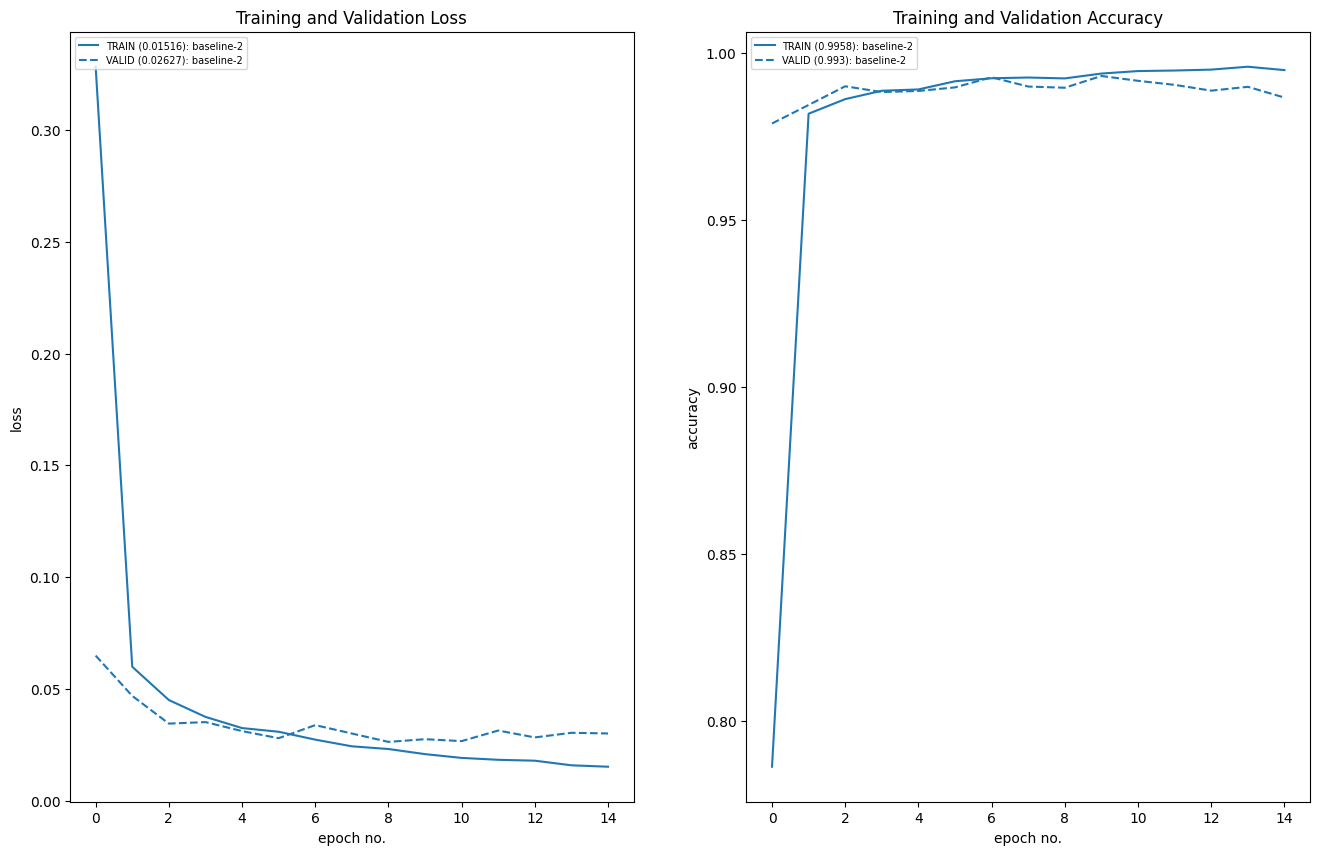

In [ ]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['baseline-2'],
                   colors=['blue'],
                   loss_legend_loc='upper left',
                   acc_legend_loc='upper left',
                   legend_font=7)

Target:

1.Improve the baseline model with dropout added after every transitioin block
2.Improve the expanded model ie model with more kernels and more layers with dropout added

Results:\
Parameters: 9k\
Best Training Accuracy: 99.45\
Best Test Accuracy: 99.19

Analysis:
1. Adding Dropout has resulted in closing the gap for train and test metrics

Application of Dropouts within layers

In [21]:
class Mnist_Baseline_DropoutA(nn.Module):

  def __init__(self, in_channels, hidden_units, out_channels):
    super(Mnist_Baseline_DropoutA, self).__init__()

    # 3 sets of convolution blocks with batchnorm added
    self.conv1 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=in_channels, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #26,3
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        #set-2
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,  kernel_size=3, stride=1, padding=0), #24,5
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        #set-3
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,  kernel_size=3, stride=1, padding=0),#22,7
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
    )

    # transition block with 1,1 mixer and maxpool added after it ie condense and compress
    self.transition = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=1, stride=1, padding=0), #22,8
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2) #11,8
    )

    # 3 sets of convolution blocks with batchnorm added
    self.conv2 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #9,12
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        #set-2
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #7,16
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        #set-3
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=1, stride=1, padding=0), #7,20
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
    )

    self.classifier = nn.Sequential(nn.Conv2d(in_channels=hidden_units, out_channels=out_channels, kernel_size=7, stride=1, padding=0)) # 7*7 kernel as classifier


  def forward(self, x):
      x = self.conv1(x)
      x = self.transition(x)
      x = self.conv2(x)
      x = self.classifier(x)
      x = x.view(-1, 10)
      return F.log_softmax(x, dim=-1)

In [23]:
# New Model Instance
baseline_model_dp = Mnist_Baseline_DropoutA(in_channels=1,hidden_units=10,out_channels=10).to(device)
summary(baseline_model_dp, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             910
       BatchNorm2d-6           [-1, 10, 24, 24]              20
              ReLU-7           [-1, 10, 24, 24]               0
           Dropout-8           [-1, 10, 24, 24]               0
            Conv2d-9           [-1, 10, 22, 22]             910
      BatchNorm2d-10           [-1, 10, 22, 22]              20
             ReLU-11           [-1, 10, 22, 22]               0
          Dropout-12           [-1, 10, 22, 22]               0
           Conv2d-13           [-1, 10, 22, 22]             110
      BatchNorm2d-14           [-1, 10,

In [24]:
# driver setup----
# optmizer
optimizer = optim.Adam(baseline_model_dp.parameters(), lr=lr)
# loss
criterion = nn.CrossEntropyLoss()
# metric
metric = MulticlassAccuracy(device = device, num_classes=10)

In [25]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(baseline_model_dp, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(baseline_model_dp, device, test_loader, criterion, metric, test_losses, test_metrics)

Epoch 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Avg Train Loss: 0.2946170336687997 Avg Train Metric: 0.8183816088987058: 100%|██████████| 469/469 [00:21<00:00, 21.45it/s]


Function Took 21.8773 seconds


Avg Test Loss: 0.10759392823976806 Avg Test Metric: 0.9691381884526603: 100%|██████████| 79/79 [00:03<00:00, 23.44it/s]


Function Took 3.3770 seconds
Epoch 1


Avg Train Loss: 0.07806353307148414 Avg Train Metric: 0.9750702846279022: 100%|██████████| 469/469 [00:24<00:00, 19.17it/s]


Function Took 24.4779 seconds


Avg Test Loss: 0.05366245222195417 Avg Test Metric: 0.9834723223613787: 100%|██████████| 79/79 [00:02<00:00, 28.66it/s]


Function Took 2.7658 seconds
Epoch 2


Avg Train Loss: 0.060000311946675086 Avg Train Metric: 0.9809797186332979: 100%|██████████| 469/469 [00:23<00:00, 19.84it/s]


Function Took 23.6449 seconds


Avg Test Loss: 0.05285215487444325 Avg Test Metric: 0.9842897615855253: 100%|██████████| 79/79 [00:02<00:00, 28.22it/s]


Function Took 2.8082 seconds
Epoch 3


Avg Train Loss: 0.051647802985120395 Avg Train Metric: 0.9834049929942149: 100%|██████████| 469/469 [00:25<00:00, 18.55it/s]


Function Took 25.2895 seconds


Avg Test Loss: 0.04274239010601953 Avg Test Metric: 0.9873253348507459: 100%|██████████| 79/79 [00:02<00:00, 28.86it/s]


Function Took 2.7438 seconds
Epoch 4


Avg Train Loss: 0.047373368862027455 Avg Train Metric: 0.9850680612043531: 100%|██████████| 469/469 [00:24<00:00, 19.52it/s]


Function Took 24.0338 seconds


Avg Test Loss: 0.04354427835632917 Avg Test Metric: 0.9838443662546859: 100%|██████████| 79/79 [00:03<00:00, 25.34it/s]


Function Took 3.1288 seconds
Epoch 5


Avg Train Loss: 0.04285895071232687 Avg Train Metric: 0.9867936035971652: 100%|██████████| 469/469 [00:22<00:00, 21.17it/s]


Function Took 22.1603 seconds


Avg Test Loss: 0.03851475873726267 Avg Test Metric: 0.9864834788479383: 100%|██████████| 79/79 [00:03<00:00, 21.15it/s]


Function Took 3.7426 seconds
Epoch 6


Avg Train Loss: 0.040760372647705836 Avg Train Metric: 0.9862106733484817: 100%|██████████| 469/469 [00:22<00:00, 20.57it/s]


Function Took 22.8100 seconds


Avg Test Loss: 0.03562287130515398 Avg Test Metric: 0.9870602488517761: 100%|██████████| 79/79 [00:02<00:00, 28.73it/s]


Function Took 2.7599 seconds
Epoch 7


Avg Train Loss: 0.03983278514177942 Avg Train Metric: 0.9878107801175067: 100%|██████████| 469/469 [00:23<00:00, 19.92it/s]


Function Took 23.5509 seconds


Avg Test Loss: 0.03436479425938989 Avg Test Metric: 0.9899916211261025: 100%|██████████| 79/79 [00:02<00:00, 28.77it/s]


Function Took 2.7537 seconds
Epoch 8


Avg Train Loss: 0.03701256725913299 Avg Train Metric: 0.9887097896035038: 100%|██████████| 469/469 [00:23<00:00, 20.17it/s]


Function Took 23.2596 seconds


Avg Test Loss: 0.035861416585755215 Avg Test Metric: 0.988987373400338: 100%|██████████| 79/79 [00:02<00:00, 26.35it/s]


Function Took 3.0085 seconds
Epoch 9


Avg Train Loss: 0.03557493391313723 Avg Train Metric: 0.9890325764603198: 100%|██████████| 469/469 [00:21<00:00, 21.46it/s]


Function Took 21.8589 seconds


Avg Test Loss: 0.035382050370997925 Avg Test Metric: 0.9879325937621201: 100%|██████████| 79/79 [00:03<00:00, 21.75it/s]


Function Took 3.6446 seconds
Epoch 10


Avg Train Loss: 0.03223358077416097 Avg Train Metric: 0.9905136772818657: 100%|██████████| 469/469 [00:22<00:00, 20.65it/s]


Function Took 22.7195 seconds


Avg Test Loss: 0.03328021709170617 Avg Test Metric: 0.9903061555910714: 100%|██████████| 79/79 [00:02<00:00, 28.41it/s]


Function Took 2.7882 seconds
Epoch 11


Avg Train Loss: 0.03304002020703649 Avg Train Metric: 0.9893978502450467: 100%|██████████| 469/469 [00:25<00:00, 18.56it/s]


Function Took 25.2812 seconds


Avg Test Loss: 0.03330287843194048 Avg Test Metric: 0.988177408900442: 100%|██████████| 79/79 [00:02<00:00, 27.98it/s]


Function Took 2.8301 seconds
Epoch 12


Avg Train Loss: 0.031848836913585726 Avg Train Metric: 0.9906937615957849: 100%|██████████| 469/469 [00:23<00:00, 19.71it/s]


Function Took 23.7987 seconds


Avg Test Loss: 0.034112615422404645 Avg Test Metric: 0.987899929662294: 100%|██████████| 79/79 [00:02<00:00, 28.17it/s]


Function Took 2.8152 seconds
Epoch 13


Avg Train Loss: 0.029449887976828796 Avg Train Metric: 0.9901573100069693: 100%|██████████| 469/469 [00:22<00:00, 21.14it/s]


Function Took 22.1972 seconds


Avg Test Loss: 0.02904118960605392 Avg Test Metric: 0.9908851460565494: 100%|██████████| 79/79 [00:04<00:00, 19.18it/s]


Function Took 4.1267 seconds
Epoch 14


Avg Train Loss: 0.02924591800106614 Avg Train Metric: 0.9905549469532997: 100%|██████████| 469/469 [00:22<00:00, 21.25it/s]


Function Took 22.0815 seconds


Avg Test Loss: 0.030527292232064508 Avg Test Metric: 0.9906788385367091: 100%|██████████| 79/79 [00:02<00:00, 28.65it/s]

Function Took 2.7659 seconds


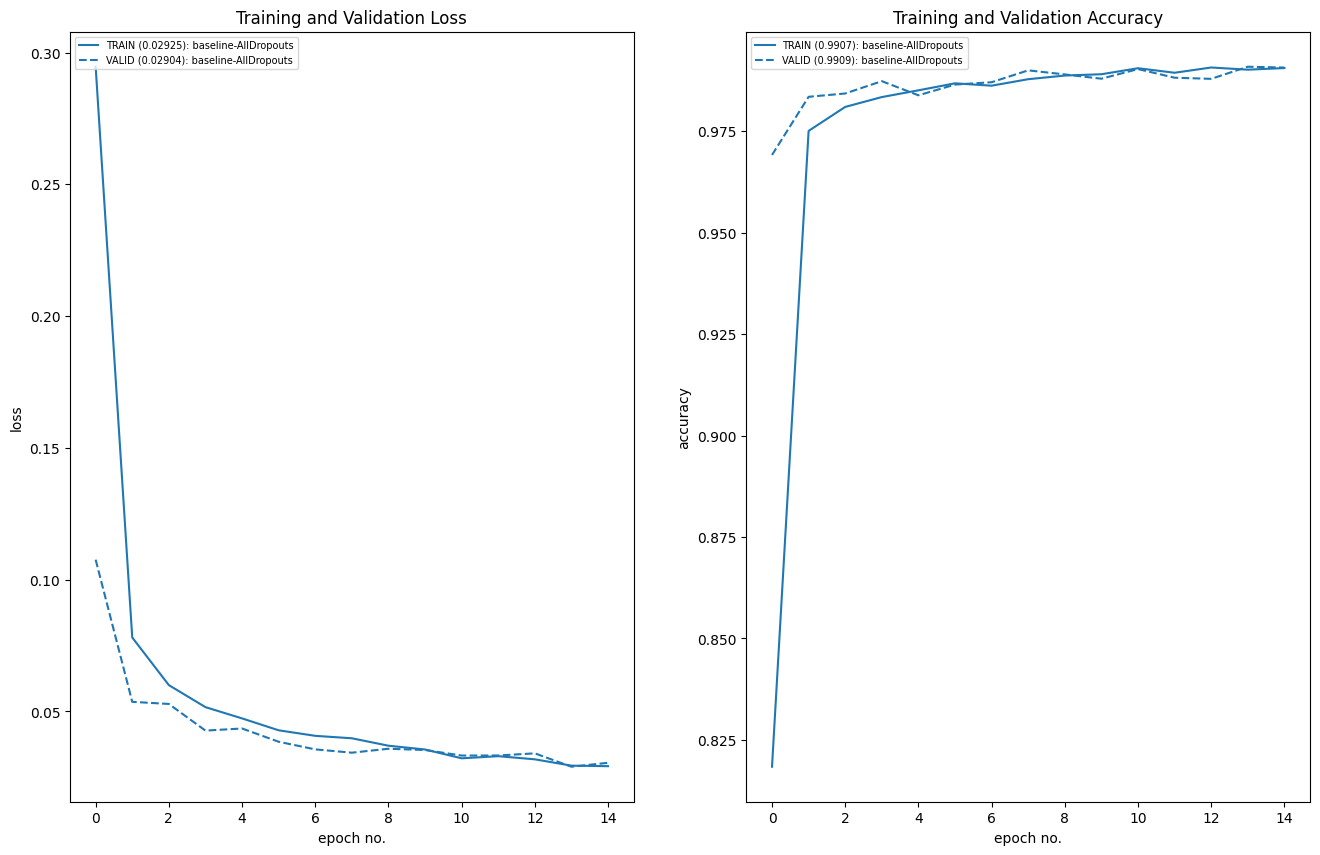

In [26]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['baseline-AllDropouts'],
                   colors=['blue'],
                   loss_legend_loc='upper left',
                   acc_legend_loc='upper left',
                   legend_font=7)

Target:

1. Minimize the gap between train and test metrics using dropouts within layers

Results:\
Parameters: 9k\
Best Training Accuracy: 99.07\
Best Test Accuracy: 99.09

Analysis:
1. First time we see better validation acc consistently that train metrics

## Addition of GAP as final layer instead of 7,7 kernel to make space for more additions of kernel

In [30]:
class Mnist_GAP_DP(nn.Module):

  def __init__(self, in_channels, hidden_units, out_channels):
    super(Mnist_GAP_DP, self).__init__()

    # 3 sets of convolution blocks with batchnorm added
    self.conv1 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=in_channels, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #26,3
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        #set-2
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units*2,  kernel_size=3, stride=1, padding=0), #24,5
        nn.BatchNorm2d(hidden_units*2),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        #set-3
        nn.Conv2d(in_channels=hidden_units*2, out_channels=hidden_units,  kernel_size=3, stride=1, padding=0),#22,7
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
    )

    # transition block with 1,1 mixer and maxpool added after it ie condense and compress
    self.transition = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=1, stride=1, padding=0), #22,8
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2) #11,8
    )

    # 3 sets of convolution blocks with batchnorm added
    self.conv2 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #9,12
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        #set-2
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units*2, kernel_size=3, stride=1, padding=0), #7,16
        nn.BatchNorm2d(hidden_units*2),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        #set-3
        nn.Conv2d(in_channels=hidden_units*2, out_channels=out_channels, kernel_size=1, stride=1, padding=0), #7,20
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
    )

    self.classifier = nn.AdaptiveAvgPool2d((1,1))


  def forward(self, x):
      x = self.conv1(x)
      x = self.transition(x)
      x = self.conv2(x)
      x = self.classifier(x)
      x = x.view(-1, 10)
      return F.log_softmax(x, dim=-1)

In [32]:
# New Model Instance
baseline_model_gap = Mnist_GAP_DP(in_channels=1,hidden_units=12,out_channels=10).to(device)
summary(baseline_model_gap, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             120
       BatchNorm2d-2           [-1, 12, 26, 26]              24
              ReLU-3           [-1, 12, 26, 26]               0
           Dropout-4           [-1, 12, 26, 26]               0
            Conv2d-5           [-1, 24, 24, 24]           2,616
       BatchNorm2d-6           [-1, 24, 24, 24]              48
              ReLU-7           [-1, 24, 24, 24]               0
           Dropout-8           [-1, 24, 24, 24]               0
            Conv2d-9           [-1, 12, 22, 22]           2,604
      BatchNorm2d-10           [-1, 12, 22, 22]              24
             ReLU-11           [-1, 12, 22, 22]               0
          Dropout-12           [-1, 12, 22, 22]               0
           Conv2d-13           [-1, 12, 22, 22]             156
      BatchNorm2d-14           [-1, 12,

In [33]:
# driver setup----
# optmizer
optimizer = optim.Adam(baseline_model_gap.parameters(), lr=lr)
# loss
criterion = nn.CrossEntropyLoss()
# metric
metric = MulticlassAccuracy(device = device, num_classes=10)

In [34]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(baseline_model_gap, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(baseline_model_gap, device, test_loader, criterion, metric, test_losses, test_metrics)

Epoch 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Avg Train Loss: 1.0769969499441607 Avg Train Metric: 0.7213108968505981: 100%|██████████| 469/469 [00:23<00:00, 19.86it/s]


Function Took 23.6252 seconds


Avg Test Loss: 0.5708400629743745 Avg Test Metric: 0.9397522135625912: 100%|██████████| 79/79 [00:02<00:00, 27.87it/s]


Function Took 2.8426 seconds
Epoch 1


Avg Train Loss: 0.455636581759463 Avg Train Metric: 0.9482621628084162: 100%|██████████| 469/469 [00:23<00:00, 19.80it/s]


Function Took 23.7005 seconds


Avg Test Loss: 0.34937119068978706 Avg Test Metric: 0.956865326513218: 100%|██████████| 79/79 [00:03<00:00, 22.07it/s]


Function Took 3.5856 seconds
Epoch 2


Avg Train Loss: 0.297965956935242 Avg Train Metric: 0.9628619677476538: 100%|██████████| 469/469 [00:33<00:00, 13.98it/s]


Function Took 33.5696 seconds


Avg Test Loss: 0.23444493775126302 Avg Test Metric: 0.969394360916524: 100%|██████████| 79/79 [00:04<00:00, 17.23it/s]


Function Took 4.6040 seconds
Epoch 3


Avg Train Loss: 0.21993207963290753 Avg Train Metric: 0.9712764539444116: 100%|██████████| 469/469 [00:30<00:00, 15.33it/s]


Function Took 30.6072 seconds


Avg Test Loss: 0.18512402625778054 Avg Test Metric: 0.9745172149018396: 100%|██████████| 79/79 [00:04<00:00, 17.87it/s]


Function Took 4.4415 seconds
Epoch 4


Avg Train Loss: 0.17452000037058077 Avg Train Metric: 0.9738486120695753: 100%|██████████| 469/469 [00:24<00:00, 19.06it/s]


Function Took 24.6148 seconds


Avg Test Loss: 0.12382691212092774 Avg Test Metric: 0.9832579855677448: 100%|██████████| 79/79 [00:03<00:00, 22.79it/s]


Function Took 3.4799 seconds
Epoch 5


Avg Train Loss: 0.14429719315599532 Avg Train Metric: 0.9785695650430122: 100%|██████████| 469/469 [00:24<00:00, 19.22it/s]


Function Took 24.4093 seconds


Avg Test Loss: 0.09770460436238518 Avg Test Metric: 0.9849803591076332: 100%|██████████| 79/79 [00:04<00:00, 18.56it/s]


Function Took 4.2735 seconds
Epoch 6


Avg Train Loss: 0.12349427488249248 Avg Train Metric: 0.9790512294149094: 100%|██████████| 469/469 [00:33<00:00, 14.03it/s]


Function Took 33.4359 seconds


Avg Test Loss: 0.09477413653195658 Avg Test Metric: 0.9829075894778287: 100%|██████████| 79/79 [00:04<00:00, 19.29it/s]


Function Took 4.1036 seconds
Epoch 7


Avg Train Loss: 0.10756391681619544 Avg Train Metric: 0.9805331739789641: 100%|██████████| 469/469 [00:29<00:00, 15.86it/s]


Function Took 29.5886 seconds


Avg Test Loss: 0.08185388430764404 Avg Test Metric: 0.9832134133652796: 100%|██████████| 79/79 [00:03<00:00, 20.07it/s]


Function Took 3.9558 seconds
Epoch 8


Avg Train Loss: 0.09766389501850996 Avg Train Metric: 0.9825048731334174: 100%|██████████| 469/469 [00:31<00:00, 15.05it/s]


Function Took 31.1818 seconds


Avg Test Loss: 0.0817483170783218 Avg Test Metric: 0.9824548363685608: 100%|██████████| 79/79 [00:05<00:00, 13.45it/s]


Function Took 5.8801 seconds
Epoch 9


Avg Train Loss: 0.0863234182077049 Avg Train Metric: 0.9826470730401305: 100%|██████████| 469/469 [00:31<00:00, 14.84it/s]


Function Took 31.6110 seconds


Avg Test Loss: 0.06355553094439115 Avg Test Metric: 0.9847492190855968: 100%|██████████| 79/79 [00:04<00:00, 19.31it/s]


Function Took 4.1004 seconds
Epoch 10


Avg Train Loss: 0.07833838220566575 Avg Train Metric: 0.9836248852042501: 100%|██████████| 469/469 [00:32<00:00, 14.30it/s]


Function Took 32.8004 seconds


Avg Test Loss: 0.06017094501588918 Avg Test Metric: 0.9863062795204453: 100%|██████████| 79/79 [00:03<00:00, 20.76it/s]


Function Took 3.8129 seconds
Epoch 11


Avg Train Loss: 0.07244938304985384 Avg Train Metric: 0.9848925025224178: 100%|██████████| 469/469 [00:22<00:00, 20.51it/s]


Function Took 22.8706 seconds


Avg Test Loss: 0.055224195676796796 Avg Test Metric: 0.9854769767085209: 100%|██████████| 79/79 [00:02<00:00, 27.44it/s]


Function Took 2.8871 seconds
Epoch 12


Avg Train Loss: 0.06657503249008519 Avg Train Metric: 0.986287666155077: 100%|██████████| 469/469 [00:24<00:00, 19.32it/s]


Function Took 24.2934 seconds


Avg Test Loss: 0.05133714883505732 Avg Test Metric: 0.9862564228758027: 100%|██████████| 79/79 [00:02<00:00, 27.88it/s]


Function Took 2.8442 seconds
Epoch 13


Avg Train Loss: 0.06222382740083852 Avg Train Metric: 0.9867306333869251: 100%|██████████| 469/469 [00:24<00:00, 19.46it/s]


Function Took 24.1081 seconds


Avg Test Loss: 0.04644236415388841 Avg Test Metric: 0.9885663171357746: 100%|██████████| 79/79 [00:02<00:00, 28.22it/s]


Function Took 2.8114 seconds
Epoch 14


Avg Train Loss: 0.0595377987858329 Avg Train Metric: 0.9865942796918629: 100%|██████████| 469/469 [00:22<00:00, 20.50it/s]


Function Took 22.8859 seconds


Avg Test Loss: 0.042959173764043214 Avg Test Metric: 0.9878839141205896: 100%|██████████| 79/79 [00:04<00:00, 19.58it/s]

Function Took 4.0415 seconds


Target:

1. Replace the 7,7 conv kernel with GAP as final layer instead of 7,7 kernel to make space for more additions of kernel

Results:\
Parameters: 9.8k\
Best Training Accuracy: 99.07\
Best Test Accuracy: 99.09

Analysis:
1. Not performing as expected, not any substantial improvement seen
2. Perfomance went down

##Best Trials Model ( Based on all of above learnings)
* Application of Transition layer after 5 RF so cutting down to 2 cnn layer in the first block
* Increased capacity in second block with more CNN layers
* Use of 16 kernels instead of 10 or 12 but no kernel doubling up
* Use of a 1,1 CNN classifier after GAP layer
* Batchnorm and dropout at each layer

In [51]:
class Mnist_Champ_Model(nn.Module):

  def __init__(self, in_channels, hidden_units, out_channels):
    super(Mnist_Champ_Model, self).__init__()

    # 3 sets of convolution blocks with batchnorm added
    self.conv1 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=in_channels, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #26,3
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        #set-2
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,  kernel_size=3, stride=1, padding=0), #24,5
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
    )

    # transition block with 1,1 mixer and maxpool added after it ie condense and compress
    self.transition = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=1, stride=1, padding=0), #24,6
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2) #12,6
    )

    # 3 sets of convolution blocks with batchnorm added
    self.conv2 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #10,10
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        #set-2
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #8,14
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        #set-3
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=1, stride=1, padding=0), #6,18
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        #set-4
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=1, stride=1, padding=0), #4,22
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),

    )

    self.gap = nn.AdaptiveAvgPool2d((1,1))
    self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units, out_channels)
    )


  def forward(self, x):
      x = self.conv1(x)
      x = self.transition(x)
      x = self.conv2(x)
      x = self.gap(x)
      x = self.classifier(x)

      return F.log_softmax(x, dim=-1)

In [52]:
# New Model Instance
champ_model = Mnist_Champ_Model(in_channels=1,hidden_units=16,out_channels=10).to(device)
summary(champ_model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
       BatchNorm2d-2           [-1, 16, 26, 26]              32
              ReLU-3           [-1, 16, 26, 26]               0
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,320
       BatchNorm2d-6           [-1, 16, 24, 24]              32
              ReLU-7           [-1, 16, 24, 24]               0
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 16, 24, 24]             272
      BatchNorm2d-10           [-1, 16, 24, 24]              32
             ReLU-11           [-1, 16, 24, 24]               0
        MaxPool2d-12           [-1, 16, 12, 12]               0
           Conv2d-13           [-1, 16, 10, 10]           2,320
      BatchNorm2d-14           [-1, 16,

In [53]:
# driver setup----
# optmizer
optimizer = optim.Adam(champ_model.parameters(), lr=lr)
# loss
criterion = nn.CrossEntropyLoss()
# metric
metric = MulticlassAccuracy(device = device, num_classes=10)

In [54]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(champ_model, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(champ_model, device, test_loader, criterion, metric, test_losses, test_metrics)

Epoch 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Avg Train Loss: 1.2513732063744876 Avg Train Metric: 0.49341261169231776: 100%|██████████| 469/469 [00:22<00:00, 20.92it/s]


Function Took 22.4362 seconds


Avg Test Loss: 0.40637485437755344 Avg Test Metric: 0.9419989050189151: 100%|██████████| 79/79 [00:03<00:00, 23.52it/s]


Function Took 3.3678 seconds
Epoch 1


Avg Train Loss: 0.27127344763355216 Avg Train Metric: 0.9500069845714041: 100%|██████████| 469/469 [00:21<00:00, 22.06it/s]


Function Took 21.2742 seconds


Avg Test Loss: 0.16157053891993775 Avg Test Metric: 0.9679367836517624: 100%|██████████| 79/79 [00:03<00:00, 26.21it/s]


Function Took 3.0230 seconds
Epoch 2


Avg Train Loss: 0.1477375674063463 Avg Train Metric: 0.9664119295219877: 100%|██████████| 469/469 [00:22<00:00, 21.04it/s]


Function Took 22.3012 seconds


Avg Test Loss: 0.11472391341871853 Avg Test Metric: 0.9717645267897015: 100%|██████████| 79/79 [00:03<00:00, 25.40it/s]


Function Took 3.1225 seconds
Epoch 3


Avg Train Loss: 0.11055063122688834 Avg Train Metric: 0.972346318810225: 100%|██████████| 469/469 [00:23<00:00, 19.69it/s]


Function Took 23.8288 seconds


Avg Test Loss: 0.09914111845855471 Avg Test Metric: 0.9740736741053907: 100%|██████████| 79/79 [00:02<00:00, 28.92it/s]


Function Took 2.7415 seconds
Epoch 4


Avg Train Loss: 0.08999083231268788 Avg Train Metric: 0.976203226712721: 100%|██████████| 469/469 [00:24<00:00, 19.44it/s]


Function Took 24.1328 seconds


Avg Test Loss: 0.08240207536971267 Avg Test Metric: 0.9743339796609516: 100%|██████████| 79/79 [00:03<00:00, 20.55it/s]


Function Took 3.8567 seconds
Epoch 5


Avg Train Loss: 0.07636468612483696 Avg Train Metric: 0.9808478852324902: 100%|██████████| 469/469 [00:28<00:00, 16.43it/s]


Function Took 28.5639 seconds


Avg Test Loss: 0.07300131393101396 Avg Test Metric: 0.9806547172461884: 100%|██████████| 79/79 [00:03<00:00, 22.40it/s]


Function Took 3.5467 seconds
Epoch 6


Avg Train Loss: 0.06860710167760915 Avg Train Metric: 0.9818409358514651: 100%|██████████| 469/469 [00:26<00:00, 17.79it/s]


Function Took 26.3652 seconds


Avg Test Loss: 0.054105423561804276 Avg Test Metric: 0.9822368493563012: 100%|██████████| 79/79 [00:02<00:00, 27.05it/s]


Function Took 2.9279 seconds
Epoch 7


Avg Train Loss: 0.06536982352259571 Avg Train Metric: 0.9819310939134057: 100%|██████████| 469/469 [00:28<00:00, 16.28it/s]


Function Took 28.8190 seconds


Avg Test Loss: 0.057275456397004335 Avg Test Metric: 0.9835356941706017: 100%|██████████| 79/79 [00:03<00:00, 22.63it/s]


Function Took 3.5064 seconds
Epoch 8


Avg Train Loss: 0.06068821042490158 Avg Train Metric: 0.9831419074967471: 100%|██████████| 469/469 [00:24<00:00, 19.40it/s]


Function Took 24.1905 seconds


Avg Test Loss: 0.04289625408245793 Avg Test Metric: 0.9864324934874908: 100%|██████████| 79/79 [00:03<00:00, 20.38it/s]


Function Took 3.8923 seconds
Epoch 9


Avg Train Loss: 0.05568641503013845 Avg Train Metric: 0.9839127295052827: 100%|██████████| 469/469 [00:24<00:00, 19.09it/s]


Function Took 24.5819 seconds


Avg Test Loss: 0.052176979063903985 Avg Test Metric: 0.9839411762696278: 100%|██████████| 79/79 [00:02<00:00, 28.52it/s]


Function Took 2.7779 seconds
Epoch 10


Avg Train Loss: 0.05268577398108775 Avg Train Metric: 0.9852056438480613: 100%|██████████| 469/469 [00:23<00:00, 19.77it/s]


Function Took 23.7288 seconds


Avg Test Loss: 0.03767317536440265 Avg Test Metric: 0.98845741944977: 100%|██████████| 79/79 [00:03<00:00, 26.20it/s]


Function Took 3.0266 seconds
Epoch 11


Avg Train Loss: 0.04983589683335696 Avg Train Metric: 0.9849014869376794: 100%|██████████| 469/469 [00:21<00:00, 22.07it/s]


Function Took 21.2577 seconds


Avg Test Loss: 0.03797889632892005 Avg Test Metric: 0.9861795419379126: 100%|██████████| 79/79 [00:03<00:00, 23.43it/s]


Function Took 3.3836 seconds
Epoch 12


Avg Train Loss: 0.04910939171024636 Avg Train Metric: 0.9865570933834068: 100%|██████████| 469/469 [00:22<00:00, 21.15it/s]


Function Took 22.1881 seconds


Avg Test Loss: 0.03773837841021581 Avg Test Metric: 0.987487823148317: 100%|██████████| 79/79 [00:02<00:00, 28.91it/s]


Function Took 2.7383 seconds
Epoch 13


Avg Train Loss: 0.04760376091546087 Avg Train Metric: 0.9861278289925061: 100%|██████████| 469/469 [00:22<00:00, 20.87it/s]


Function Took 22.4770 seconds


Avg Test Loss: 0.04205409116760085 Avg Test Metric: 0.9889753966391841: 100%|██████████| 79/79 [00:02<00:00, 29.34it/s]


Function Took 2.7018 seconds
Epoch 14


Avg Train Loss: 0.04584449087815689 Avg Train Metric: 0.985715529811916: 100%|██████████| 469/469 [00:21<00:00, 21.34it/s]


Function Took 21.9837 seconds


Avg Test Loss: 0.04531698830755828 Avg Test Metric: 0.9855479394333272: 100%|██████████| 79/79 [00:04<00:00, 19.73it/s]

Function Took 4.0097 seconds


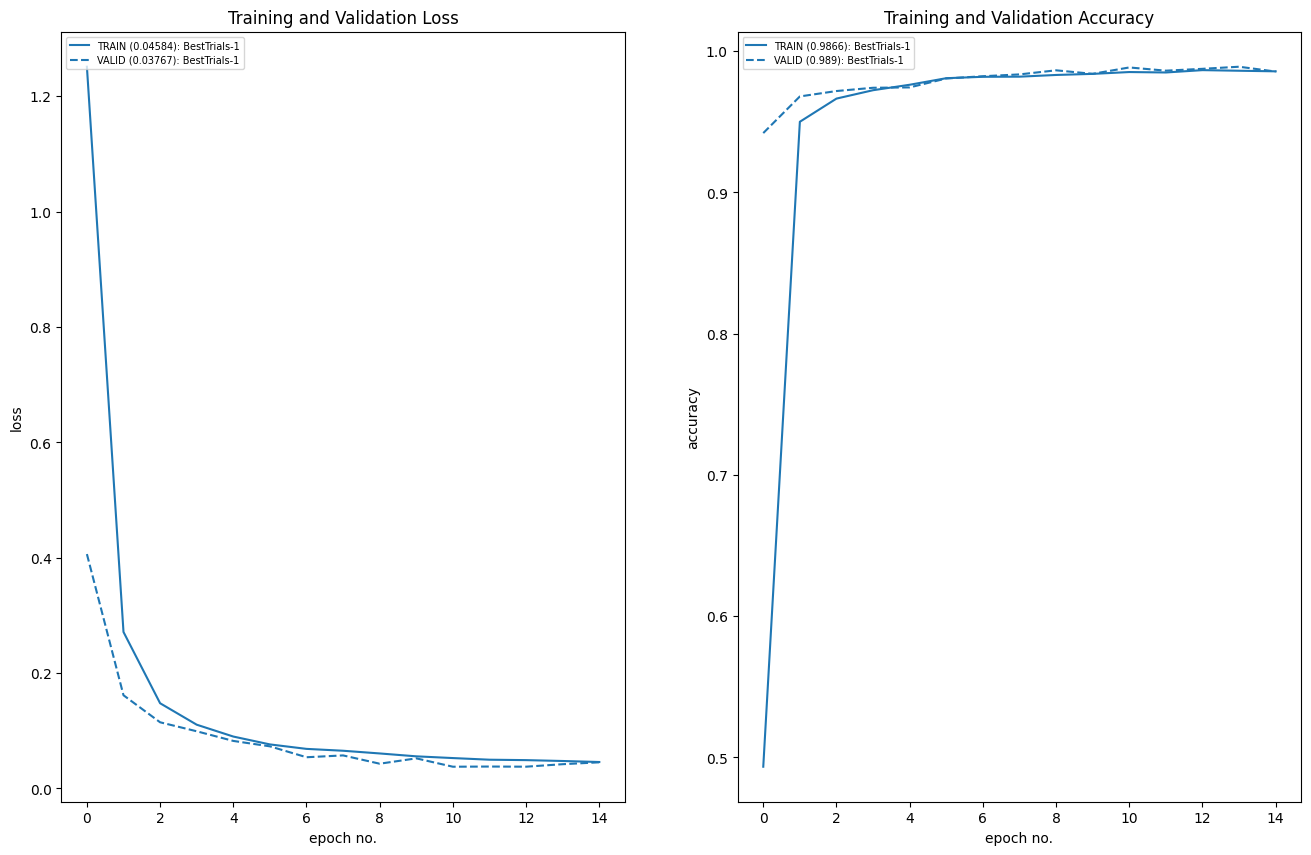

In [55]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['BestTrials-1'],
                   colors=['blue'],
                   loss_legend_loc='upper left',
                   acc_legend_loc='upper left',
                   legend_font=7)

In [83]:
class Mnist_Champ_Model_Ext(nn.Module):

  def __init__(self, in_channels, hidden_units, out_channels):
    super(Mnist_Champ_Model_Ext, self).__init__()

    # 3 sets of convolution blocks with batchnorm added
    self.conv1 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=in_channels, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #26,3
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        #set-2
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,  kernel_size=3, stride=1, padding=0), #24,5
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
    )

    # transition block with 1,1 mixer and maxpool added after it ie condense and compress
    self.transition = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=1, stride=1, padding=0), #24,6
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2) #12,6
    )

    # 3 sets of convolution blocks with batchnorm added
    self.conv2 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #10,10
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        #set-2
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #8,14
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        #set-3
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=1, stride=1, padding=0), #6,18
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        #set-4
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units*2, kernel_size=1, stride=1, padding=0), #4,22
        nn.BatchNorm2d(hidden_units*2),
        nn.ReLU(),
        nn.Dropout(p=0.1),

    )

    self.gap = nn.Sequential(
        nn.AdaptiveAvgPool2d((1,1))
    )

    self.classifier = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units*2, out_channels=out_channels, kernel_size=(1, 1), padding=0, bias=False),
        )

  def forward(self, x):
      x = self.conv1(x)
      x = self.transition(x)
      x = self.conv2(x)
      x = self.gap(x)
      x = self.classifier(x)
      x= nn.Flatten()(x)
      return F.log_softmax(x, dim=-1)

In [84]:
# New Model Instance
champ_model_ext = Mnist_Champ_Model_Ext(in_channels=1,hidden_units=16,out_channels=10).to(device)
summary(champ_model_ext, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
       BatchNorm2d-2           [-1, 16, 26, 26]              32
              ReLU-3           [-1, 16, 26, 26]               0
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,320
       BatchNorm2d-6           [-1, 16, 24, 24]              32
              ReLU-7           [-1, 16, 24, 24]               0
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 16, 24, 24]             272
      BatchNorm2d-10           [-1, 16, 24, 24]              32
             ReLU-11           [-1, 16, 24, 24]               0
        MaxPool2d-12           [-1, 16, 12, 12]               0
           Conv2d-13           [-1, 16, 10, 10]           2,320
      BatchNorm2d-14           [-1, 16,

In [85]:
# driver setup----
# optmizer
optimizer = optim.Adam(champ_model_ext.parameters(), lr=lr)
# loss
criterion = nn.CrossEntropyLoss()
# metric
metric = MulticlassAccuracy(device = device, num_classes=10)

In [86]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(champ_model_ext, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(champ_model_ext, device, test_loader, criterion, metric, test_losses, test_metrics)

Epoch 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Avg Train Loss: 0.9957817281995501 Avg Train Metric: 0.5361587491466292: 100%|██████████| 469/469 [00:24<00:00, 19.11it/s]


Function Took 24.5467 seconds


Avg Test Loss: 0.2544281169583526 Avg Test Metric: 0.9589582553392724: 100%|██████████| 79/79 [00:02<00:00, 28.28it/s]


Function Took 2.8045 seconds
Epoch 1


Avg Train Loss: 0.1976522768357161 Avg Train Metric: 0.9554597509186914: 100%|██████████| 469/469 [00:21<00:00, 21.68it/s]


Function Took 21.6444 seconds


Avg Test Loss: 0.11338056430597848 Avg Test Metric: 0.9701830865461615: 100%|██████████| 79/79 [00:03<00:00, 19.76it/s]


Function Took 4.0114 seconds
Epoch 2


Avg Train Loss: 0.11752388260956766 Avg Train Metric: 0.9695484452664471: 100%|██████████| 469/469 [00:21<00:00, 21.71it/s]


Function Took 21.6115 seconds


Avg Test Loss: 0.07825924154323867 Avg Test Metric: 0.9804023821142656: 100%|██████████| 79/79 [00:02<00:00, 26.95it/s]


Function Took 2.9388 seconds
Epoch 3


Avg Train Loss: 0.08973082062452714 Avg Train Metric: 0.9760006761500067: 100%|██████████| 469/469 [00:23<00:00, 20.19it/s]


Function Took 23.2432 seconds


Avg Test Loss: 0.06735946740247781 Avg Test Metric: 0.9789667431312271: 100%|██████████| 79/79 [00:02<00:00, 28.18it/s]


Function Took 2.8161 seconds
Epoch 4


Avg Train Loss: 0.07803813058700261 Avg Train Metric: 0.9792106429905271: 100%|██████████| 469/469 [00:23<00:00, 20.00it/s]


Function Took 23.4610 seconds


Avg Test Loss: 0.05396732468676718 Avg Test Metric: 0.9866981528982331: 100%|██████████| 79/79 [00:02<00:00, 27.93it/s]


Function Took 2.8392 seconds
Epoch 5


Avg Train Loss: 0.06739581916838694 Avg Train Metric: 0.9810436864905774: 100%|██████████| 469/469 [00:23<00:00, 20.01it/s]


Function Took 23.4486 seconds


Avg Test Loss: 0.05550994210039513 Avg Test Metric: 0.9815965483460245: 100%|██████████| 79/79 [00:03<00:00, 25.78it/s]


Function Took 3.0711 seconds
Epoch 6


Avg Train Loss: 0.06413751104469302 Avg Train Metric: 0.9820318219504123: 100%|██████████| 469/469 [00:22<00:00, 20.83it/s]


Function Took 22.5255 seconds


Avg Test Loss: 0.045801577936339224 Avg Test Metric: 0.9863971554780309: 100%|██████████| 79/79 [00:03<00:00, 20.06it/s]


Function Took 3.9482 seconds
Epoch 7


Avg Train Loss: 0.05700857813622969 Avg Train Metric: 0.9839908170547567: 100%|██████████| 469/469 [00:24<00:00, 19.36it/s]


Function Took 24.2347 seconds


Avg Test Loss: 0.04960288772288757 Avg Test Metric: 0.9828716365596916: 100%|██████████| 79/79 [00:03<00:00, 24.08it/s]


Function Took 3.2973 seconds
Epoch 8


Avg Train Loss: 0.05615371629508383 Avg Train Metric: 0.9830297906515695: 100%|██████████| 469/469 [00:23<00:00, 20.26it/s]


Function Took 23.1577 seconds


Avg Test Loss: 0.0431159710205054 Avg Test Metric: 0.9855198203762875: 100%|██████████| 79/79 [00:02<00:00, 27.66it/s]


Function Took 2.8680 seconds
Epoch 9


Avg Train Loss: 0.052722903526525124 Avg Train Metric: 0.9838725756734673: 100%|██████████| 469/469 [00:23<00:00, 20.37it/s]


Function Took 23.0319 seconds


Avg Test Loss: 0.03972434258394981 Avg Test Metric: 0.9870530947854247: 100%|██████████| 79/79 [00:02<00:00, 27.13it/s]


Function Took 2.9217 seconds
Epoch 10


Avg Train Loss: 0.048821085825689566 Avg Train Metric: 0.9856867969417369: 100%|██████████| 469/469 [00:22<00:00, 20.74it/s]


Function Took 22.6301 seconds


Avg Test Loss: 0.036765977416093214 Avg Test Metric: 0.9879008244864548: 100%|██████████| 79/79 [00:02<00:00, 27.92it/s]


Function Took 2.8398 seconds
Epoch 11


Avg Train Loss: 0.049347671988938475 Avg Train Metric: 0.9854097088008548: 100%|██████████| 469/469 [00:21<00:00, 21.57it/s]


Function Took 21.7514 seconds


Avg Test Loss: 0.03439783596999566 Avg Test Metric: 0.9879992596710785: 100%|██████████| 79/79 [00:04<00:00, 18.47it/s]


Function Took 4.2924 seconds
Epoch 12


Avg Train Loss: 0.046164513243906406 Avg Train Metric: 0.9864879908846386: 100%|██████████| 469/469 [00:22<00:00, 20.77it/s]


Function Took 22.5881 seconds


Avg Test Loss: 0.03569223871159874 Avg Test Metric: 0.9892746670336663: 100%|██████████| 79/79 [00:03<00:00, 23.80it/s]


Function Took 3.3266 seconds
Epoch 13


Avg Train Loss: 0.04596126171003686 Avg Train Metric: 0.9857099110892078: 100%|██████████| 469/469 [00:23<00:00, 20.04it/s]


Function Took 23.4171 seconds


Avg Test Loss: 0.0316879757034557 Avg Test Metric: 0.9893099627917326: 100%|██████████| 79/79 [00:02<00:00, 27.17it/s]


Function Took 2.9175 seconds
Epoch 14


Avg Train Loss: 0.04414526531810382 Avg Train Metric: 0.9869141457939962: 100%|██████████| 469/469 [00:24<00:00, 19.12it/s]


Function Took 24.5377 seconds


Avg Test Loss: 0.03752116455484323 Avg Test Metric: 0.9869082585165773: 100%|██████████| 79/79 [00:02<00:00, 28.83it/s]

Function Took 2.7466 seconds


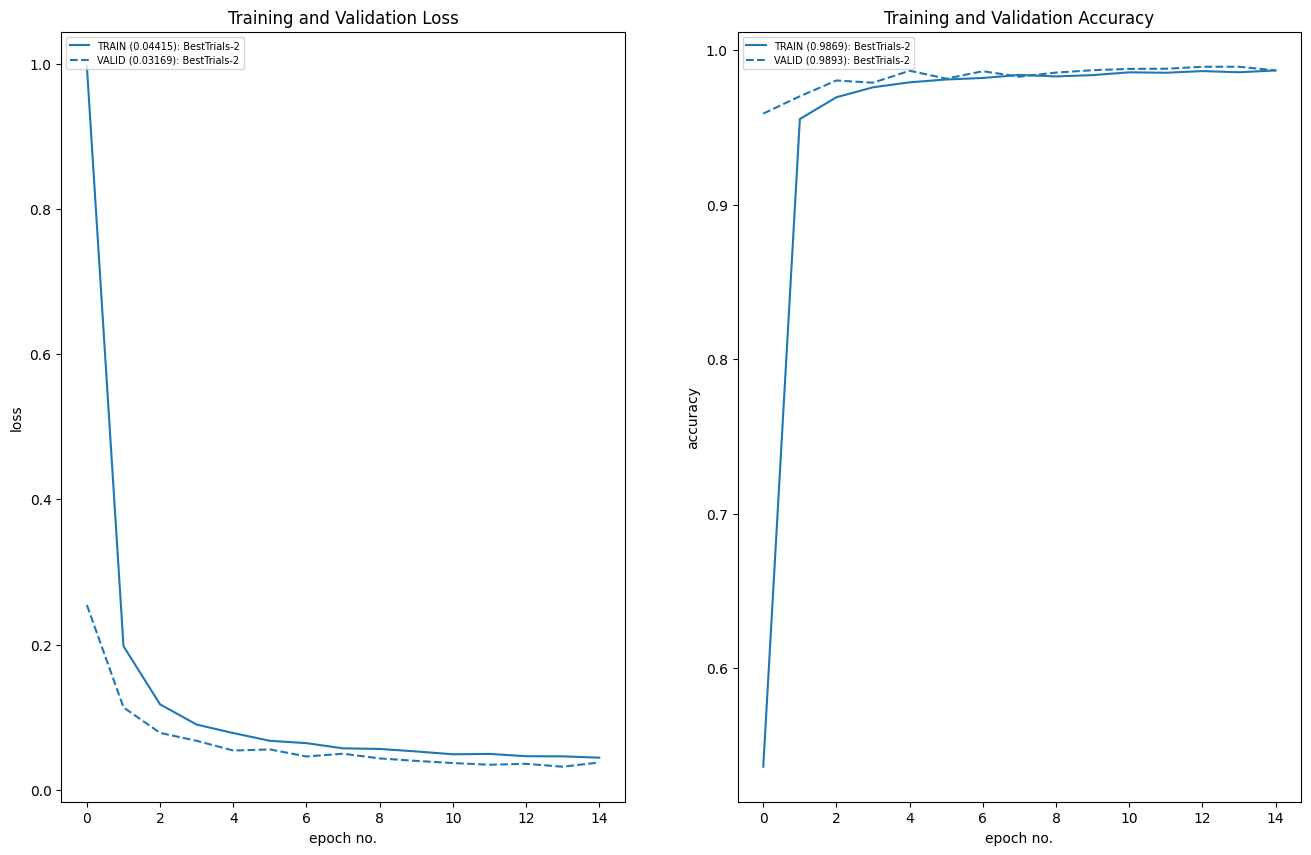

In [88]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['BestTrials-2'],
                   colors=['blue'],
                   loss_legend_loc='upper left',
                   acc_legend_loc='upper left',
                   legend_font=7)

Target:

1. Adding 1,1 classfier with expanded Network

Results:\
Parameters: 8.5-8.7k\
Best Training Accuracy: 98\
Best Test Accuracy: 98

Analysis:
1. Not performing as expected, not any substantial improvement seen
2. Perfomance went down

## LR Scheduler

In [106]:
class Mnist_Champ_Model_Ext(nn.Module):

  def __init__(self, in_channels, hidden_units, out_channels):
    super(Mnist_Champ_Model_Ext, self).__init__()

    # 3 sets of convolution blocks with batchnorm added
    self.conv1 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=in_channels, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #26,3
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        #set-2
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,  kernel_size=3, stride=1, padding=0), #24,5
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
    )

    # transition block with 1,1 mixer and maxpool added after it ie condense and compress
    self.transition = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=1, stride=1, padding=0), #24,6
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2) #12,6
    )

    # 3 sets of convolution blocks with batchnorm added
    self.conv2 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #10,10
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        #set-2
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #8,14
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        #set-3
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=1, stride=1, padding=0), #6,18
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        #set-4
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=1, stride=1, padding=0), #4,22
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),

    )

    self.gap = nn.Sequential(
        nn.AdaptiveAvgPool2d((1,1))
    )

    self.classifier = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=out_channels, kernel_size=(1, 1), padding=0, bias=False),
        )

  def forward(self, x):
      x = self.conv1(x)
      x = self.transition(x)
      x = self.conv2(x)
      x = self.gap(x)
      x = self.classifier(x)
      x= nn.Flatten()(x)
      return F.log_softmax(x, dim=-1)

In [107]:
# New Model Instance
champ_model_ext = Mnist_Champ_Model_Ext(in_channels=1,hidden_units=16,out_channels=10).to(device)
summary(champ_model_ext, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
       BatchNorm2d-2           [-1, 16, 26, 26]              32
              ReLU-3           [-1, 16, 26, 26]               0
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,320
       BatchNorm2d-6           [-1, 16, 24, 24]              32
              ReLU-7           [-1, 16, 24, 24]               0
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 16, 24, 24]             272
      BatchNorm2d-10           [-1, 16, 24, 24]              32
             ReLU-11           [-1, 16, 24, 24]               0
        MaxPool2d-12           [-1, 16, 12, 12]               0
           Conv2d-13           [-1, 16, 10, 10]           2,320
      BatchNorm2d-14           [-1, 16,

In [109]:
# driver setup----
# optmizer
optimizer = optim.Adam(champ_model_ext.parameters(), lr=1e-2)
# loss
criterion = nn.CrossEntropyLoss()
# metric
metric = MulticlassAccuracy(device = device, num_classes=10)
# LR Scheduler - Exponential
lr_scheduler = ExponentialLR(optimizer,gamma = 0.8) # lr_t = lr_t-1 * gamma

In [110]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(champ_model_ext, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(champ_model_ext, device, test_loader, criterion, metric, test_losses, test_metrics)
  lr_scheduler.step() # lr scheduler stepping
  print(f"For next epoch {lr_scheduler.get_last_lr()[0]}")

Epoch 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Avg Train Loss: 0.3859185470478621 Avg Train Metric: 0.7359340326237017: 100%|██████████| 469/469 [00:22<00:00, 20.89it/s]


Function Took 22.4595 seconds


Avg Test Loss: 0.08746052149070214 Avg Test Metric: 0.9731469546692281: 100%|██████████| 79/79 [00:03<00:00, 25.70it/s]


Function Took 3.0844 seconds
For next epoch 0.008
Epoch 1


Avg Train Loss: 0.09750323277165386 Avg Train Metric: 0.970086971198572: 100%|██████████| 469/469 [00:20<00:00, 22.49it/s]


Function Took 20.8620 seconds


Avg Test Loss: 0.15294798836112022 Avg Test Metric: 0.9506346832347822: 100%|██████████| 79/79 [00:03<00:00, 21.68it/s]


Function Took 3.6532 seconds
For next epoch 0.0064
Epoch 2


Avg Train Loss: 0.07649475155171873 Avg Train Metric: 0.9769157135664527: 100%|██████████| 469/469 [00:23<00:00, 20.27it/s]


Function Took 23.1499 seconds


Avg Test Loss: 0.05547164910461141 Avg Test Metric: 0.9818840177753304: 100%|██████████| 79/79 [00:02<00:00, 28.71it/s]


Function Took 2.7582 seconds
For next epoch 0.00512
Epoch 3


Avg Train Loss: 0.06358346014396786 Avg Train Metric: 0.9811790176291963: 100%|██████████| 469/469 [00:22<00:00, 20.99it/s]


Function Took 22.3616 seconds


Avg Test Loss: 0.04607107937689635 Avg Test Metric: 0.9824521813211562: 100%|██████████| 79/79 [00:02<00:00, 28.62it/s]


Function Took 2.7667 seconds
For next epoch 0.004096000000000001
Epoch 4


Avg Train Loss: 0.05792005860538625 Avg Train Metric: 0.9806224926194148: 100%|██████████| 469/469 [00:20<00:00, 22.50it/s]


Function Took 20.8548 seconds


Avg Test Loss: 0.04656985386486955 Avg Test Metric: 0.9858929069736336: 100%|██████████| 79/79 [00:04<00:00, 19.66it/s]


Function Took 4.0306 seconds
For next epoch 0.0032768000000000007
Epoch 5


Avg Train Loss: 0.05226669759491582 Avg Train Metric: 0.9838171944435217: 100%|██████████| 469/469 [00:21<00:00, 22.29it/s]


Function Took 21.0518 seconds


Avg Test Loss: 0.04030410162632978 Avg Test Metric: 0.9850963557822795: 100%|██████████| 79/79 [00:02<00:00, 29.36it/s]


Function Took 2.7012 seconds
For next epoch 0.002621440000000001
Epoch 6


Avg Train Loss: 0.0482926470692208 Avg Train Metric: 0.9847559616255608: 100%|██████████| 469/469 [00:22<00:00, 20.45it/s]


Function Took 22.9409 seconds


Avg Test Loss: 0.036332332968263874 Avg Test Metric: 0.9894409451303603: 100%|██████████| 79/79 [00:02<00:00, 27.30it/s]


Function Took 2.9021 seconds
For next epoch 0.002097152000000001
Epoch 7


Avg Train Loss: 0.0449860628852164 Avg Train Metric: 0.9855275795912184: 100%|██████████| 469/469 [00:22<00:00, 20.40it/s]


Function Took 23.0029 seconds


Avg Test Loss: 0.0349096807627644 Avg Test Metric: 0.988859465605096: 100%|██████████| 79/79 [00:02<00:00, 28.89it/s]


Function Took 2.7431 seconds
For next epoch 0.001677721600000001
Epoch 8


Avg Train Loss: 0.04079290469145295 Avg Train Metric: 0.9877295618626609: 100%|██████████| 469/469 [00:21<00:00, 21.72it/s]


Function Took 21.6073 seconds


Avg Test Loss: 0.03912210284107471 Avg Test Metric: 0.9855485958389089: 100%|██████████| 79/79 [00:04<00:00, 17.79it/s]


Function Took 4.4526 seconds
For next epoch 0.0013421772800000008
Epoch 9


Avg Train Loss: 0.04126318374366712 Avg Train Metric: 0.9880243055601873: 100%|██████████| 469/469 [00:22<00:00, 20.59it/s]


Function Took 22.7844 seconds


Avg Test Loss: 0.03317804854654978 Avg Test Metric: 0.9896065630490267: 100%|██████████| 79/79 [00:02<00:00, 27.32it/s]


Function Took 2.9002 seconds
For next epoch 0.0010737418240000006
Epoch 10


Avg Train Loss: 0.03917227699947573 Avg Train Metric: 0.9871776795336432: 100%|██████████| 469/469 [00:23<00:00, 20.29it/s]


Function Took 23.1215 seconds


Avg Test Loss: 0.03765116014246699 Avg Test Metric: 0.9873720498024663: 100%|██████████| 79/79 [00:02<00:00, 27.99it/s]


Function Took 2.8326 seconds
For next epoch 0.0008589934592000006
Epoch 11


Avg Train Loss: 0.03767376011714085 Avg Train Metric: 0.9879486413398532: 100%|██████████| 469/469 [00:23<00:00, 20.00it/s]


Function Took 23.4650 seconds


Avg Test Loss: 0.03484698688858955 Avg Test Metric: 0.9891570112373256: 100%|██████████| 79/79 [00:02<00:00, 28.11it/s]


Function Took 2.8221 seconds
For next epoch 0.0006871947673600005
Epoch 12


Avg Train Loss: 0.03678336950527357 Avg Train Metric: 0.9894824017848033: 100%|██████████| 469/469 [00:22<00:00, 20.45it/s]


Function Took 22.9454 seconds


Avg Test Loss: 0.03415143827589441 Avg Test Metric: 0.9888241419309303: 100%|██████████| 79/79 [00:02<00:00, 26.52it/s]


Function Took 2.9906 seconds
For next epoch 0.0005497558138880005
Epoch 13


Avg Train Loss: 0.03540810581141793 Avg Train Metric: 0.988424260224869: 100%|██████████| 469/469 [00:21<00:00, 21.56it/s]


Function Took 21.7615 seconds


Avg Test Loss: 0.030225793928308767 Avg Test Metric: 0.9915008424203607: 100%|██████████| 79/79 [00:04<00:00, 19.73it/s]


Function Took 4.0117 seconds
For next epoch 0.0004398046511104004
Epoch 14


Avg Train Loss: 0.03461224792241208 Avg Train Metric: 0.9890394304861138: 100%|██████████| 469/469 [00:21<00:00, 21.56it/s]


Function Took 21.7674 seconds


Avg Test Loss: 0.031230359420746187 Avg Test Metric: 0.9908930470671835: 100%|██████████| 79/79 [00:02<00:00, 29.09it/s]

Function Took 2.7240 seconds
For next epoch 0.00035184372088832035


Application of LR scheduler on Inital baseline model-- Main Game

In [25]:
class Mnist_Champ_Model_FL(nn.Module):

  def __init__(self, in_channels, hidden_units, out_channels):
    super(Mnist_Champ_Model_FL, self).__init__()

    # 3 sets of convolution blocks with batchnorm added
    self.conv1 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=in_channels, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #26,3
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        #set-2
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,  kernel_size=3, stride=1, padding=0), #24,5
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
    )

    # transition block with 1,1 mixer and maxpool added after it ie condense and compress
    self.transition = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=1, stride=1, padding=0), #24,6
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2) #12,6
    )

    # 3 sets of convolution blocks with batchnorm added
    self.conv2 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #10,10
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        #set-2
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #8,14
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        #set-3
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #6,18
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),

        # set-4
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #4,22
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),

    )

    self.classifier = nn.Sequential(nn.Conv2d(in_channels=hidden_units, out_channels=out_channels, kernel_size=4, stride=1, padding=0))
    self.dropout = nn.Dropout(p=0.1)


  def forward(self, x):
      x = self.conv1(x)
      x = self.dropout(x)
      x = self.transition(x)
      x = self.conv2(x)
      x = self.dropout(x)
      x = self.classifier(x)
      x = x.view(-1, 10)

      return F.log_softmax(x, dim=-1)

In [26]:
# New Model Instance
champ_model_1 = Mnist_Champ_Model_FL(in_channels=1, hidden_units=10, out_channels=10).to(device)
summary(champ_model_1, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]             910
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
           Dropout-7           [-1, 10, 24, 24]               0
            Conv2d-8           [-1, 10, 24, 24]             110
       BatchNorm2d-9           [-1, 10, 24, 24]              20
             ReLU-10           [-1, 10, 24, 24]               0
        MaxPool2d-11           [-1, 10, 12, 12]               0
           Conv2d-12           [-1, 10, 10, 10]             910
      BatchNorm2d-13           [-1, 10, 10, 10]              20
             ReLU-14           [-1, 10,

In [27]:
# driver setup----
# optmizer
optimizer = optim.Adam(champ_model_1.parameters(), lr=1e-2)
# loss
criterion = nn.CrossEntropyLoss()
# metric
metric = MulticlassAccuracy(device = device, num_classes=10)
# LR Scheduler - Exponential
lr_scheduler = ExponentialLR(optimizer, gamma = 0.8) # lr_t = lr_t-1 * gamma

In [28]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(champ_model_1, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(champ_model_1, device, test_loader, criterion, metric, test_losses, test_metrics)
  lr_scheduler.step() # lr scheduler stepping
  print(f"For next epoch {lr_scheduler.get_last_lr()[0]}")

Epoch 0


Avg Train Loss: 0.15996583465979233 Avg Train Metric: 0.8914641376370306: 100%|██████████| 469/469 [00:23<00:00, 20.39it/s]


Function Took 23.0125 seconds


Avg Test Loss: 0.08111949283865434 Avg Test Metric: 0.9704291880885257: 100%|██████████| 79/79 [00:03<00:00, 20.92it/s]


Function Took 3.7862 seconds
For next epoch 0.008
Epoch 1


Avg Train Loss: 0.060795811300815294 Avg Train Metric: 0.9805469258761863: 100%|██████████| 469/469 [00:28<00:00, 16.63it/s]


Function Took 28.2100 seconds


Avg Test Loss: 0.056376206747527365 Avg Test Metric: 0.9817333206345763: 100%|██████████| 79/79 [00:04<00:00, 18.60it/s]


Function Took 4.2603 seconds
For next epoch 0.0064
Epoch 2


Avg Train Loss: 0.04692168071020101 Avg Train Metric: 0.9852827599307875: 100%|██████████| 469/469 [00:30<00:00, 15.13it/s]


Function Took 30.9971 seconds


Avg Test Loss: 0.04902570101114202 Avg Test Metric: 0.9855828043780749: 100%|██████████| 79/79 [00:03<00:00, 26.31it/s]


Function Took 3.0117 seconds
For next epoch 0.00512
Epoch 3


Avg Train Loss: 0.039051821475713525 Avg Train Metric: 0.9877846303270824: 100%|██████████| 469/469 [00:22<00:00, 20.92it/s]


Function Took 22.4284 seconds


Avg Test Loss: 0.030052766454394295 Avg Test Metric: 0.9914317266850532: 100%|██████████| 79/79 [00:03<00:00, 25.97it/s]


Function Took 3.0505 seconds
For next epoch 0.004096000000000001
Epoch 4


Avg Train Loss: 0.03247264828304571 Avg Train Metric: 0.9894207499937208: 100%|██████████| 469/469 [00:21<00:00, 22.15it/s]


Function Took 21.1872 seconds


Avg Test Loss: 0.03329253862788783 Avg Test Metric: 0.9893844527534291: 100%|██████████| 79/79 [00:03<00:00, 24.39it/s]


Function Took 3.2485 seconds
For next epoch 0.0032768000000000007
Epoch 5


Avg Train Loss: 0.02798360407199544 Avg Train Metric: 0.9913758341945819: 100%|██████████| 469/469 [00:23<00:00, 20.27it/s]


Function Took 23.1415 seconds


Avg Test Loss: 0.03145091912025421 Avg Test Metric: 0.9901855399336996: 100%|██████████| 79/79 [00:02<00:00, 29.26it/s]


Function Took 2.7119 seconds
For next epoch 0.002621440000000001
Epoch 6


Avg Train Loss: 0.02467104672828614 Avg Train Metric: 0.9918996183348617: 100%|██████████| 469/469 [00:22<00:00, 20.49it/s]


Function Took 22.8975 seconds


Avg Test Loss: 0.025808477886256915 Avg Test Metric: 0.9907212687444084: 100%|██████████| 79/79 [00:02<00:00, 28.62it/s]


Function Took 2.7712 seconds
For next epoch 0.002097152000000001
Epoch 7


Avg Train Loss: 0.02188291653371684 Avg Train Metric: 0.9938533415418189: 100%|██████████| 469/469 [00:21<00:00, 21.52it/s]


Function Took 21.8023 seconds


Avg Test Loss: 0.02719102801955482 Avg Test Metric: 0.9892742015138457: 100%|██████████| 79/79 [00:03<00:00, 21.43it/s]


Function Took 3.6939 seconds
For next epoch 0.001677721600000001
Epoch 8


Avg Train Loss: 0.019774077725641406 Avg Train Metric: 0.9938681250187889: 100%|██████████| 469/469 [00:21<00:00, 21.90it/s]


Function Took 21.4237 seconds


Avg Test Loss: 0.023247251977489766 Avg Test Metric: 0.9930422751209403: 100%|██████████| 79/79 [00:02<00:00, 26.71it/s]


Function Took 2.9702 seconds
For next epoch 0.0013421772800000008
Epoch 9


Avg Train Loss: 0.01793056828796919 Avg Train Metric: 0.9942074940402879: 100%|██████████| 469/469 [00:24<00:00, 18.81it/s]


Function Took 24.9458 seconds


Avg Test Loss: 0.023528614971872207 Avg Test Metric: 0.9911836189559743: 100%|██████████| 79/79 [00:02<00:00, 28.52it/s]


Function Took 2.7761 seconds
For next epoch 0.0010737418240000006
Epoch 10


Avg Train Loss: 0.01572232191507488 Avg Train Metric: 0.9951976799507385: 100%|██████████| 469/469 [00:23<00:00, 20.32it/s]


Function Took 23.0929 seconds


Avg Test Loss: 0.023835444863063365 Avg Test Metric: 0.9918292987195751: 100%|██████████| 79/79 [00:02<00:00, 27.18it/s]


Function Took 2.9165 seconds
For next epoch 0.0008589934592000006
Epoch 11


Avg Train Loss: 0.015075635373729395 Avg Train Metric: 0.9950673087065154: 100%|██████████| 469/469 [00:21<00:00, 21.45it/s]


Function Took 21.8741 seconds


Avg Test Loss: 0.025362163228041763 Avg Test Metric: 0.9921110581748093: 100%|██████████| 79/79 [00:03<00:00, 19.93it/s]


Function Took 3.9697 seconds
For next epoch 0.0006871947673600005
Epoch 12


Avg Train Loss: 0.013009152854599162 Avg Train Metric: 0.9955843376960836: 100%|██████████| 469/469 [00:21<00:00, 21.63it/s]


Function Took 21.6916 seconds


Avg Test Loss: 0.024068885212808352 Avg Test Metric: 0.9925398268277132: 100%|██████████| 79/79 [00:02<00:00, 27.58it/s]


Function Took 2.8784 seconds
For next epoch 0.0005497558138880005
Epoch 13


Avg Train Loss: 0.012566860927182483 Avg Train Metric: 0.9961490211710493: 100%|██████████| 469/469 [00:22<00:00, 20.45it/s]


Function Took 22.9428 seconds


Avg Test Loss: 0.02395541741898802 Avg Test Metric: 0.9923036000396632: 100%|██████████| 79/79 [00:02<00:00, 28.33it/s]


Function Took 2.7995 seconds
For next epoch 0.0004398046511104004
Epoch 14


Avg Train Loss: 0.011954752747828304 Avg Train Metric: 0.9964579803857214: 100%|██████████| 469/469 [00:25<00:00, 18.14it/s]


Function Took 25.8662 seconds


Avg Test Loss: 0.024658746598325256 Avg Test Metric: 0.994280210778683: 100%|██████████| 79/79 [00:04<00:00, 17.41it/s]

Function Took 4.5583 seconds
For next epoch 0.00035184372088832035


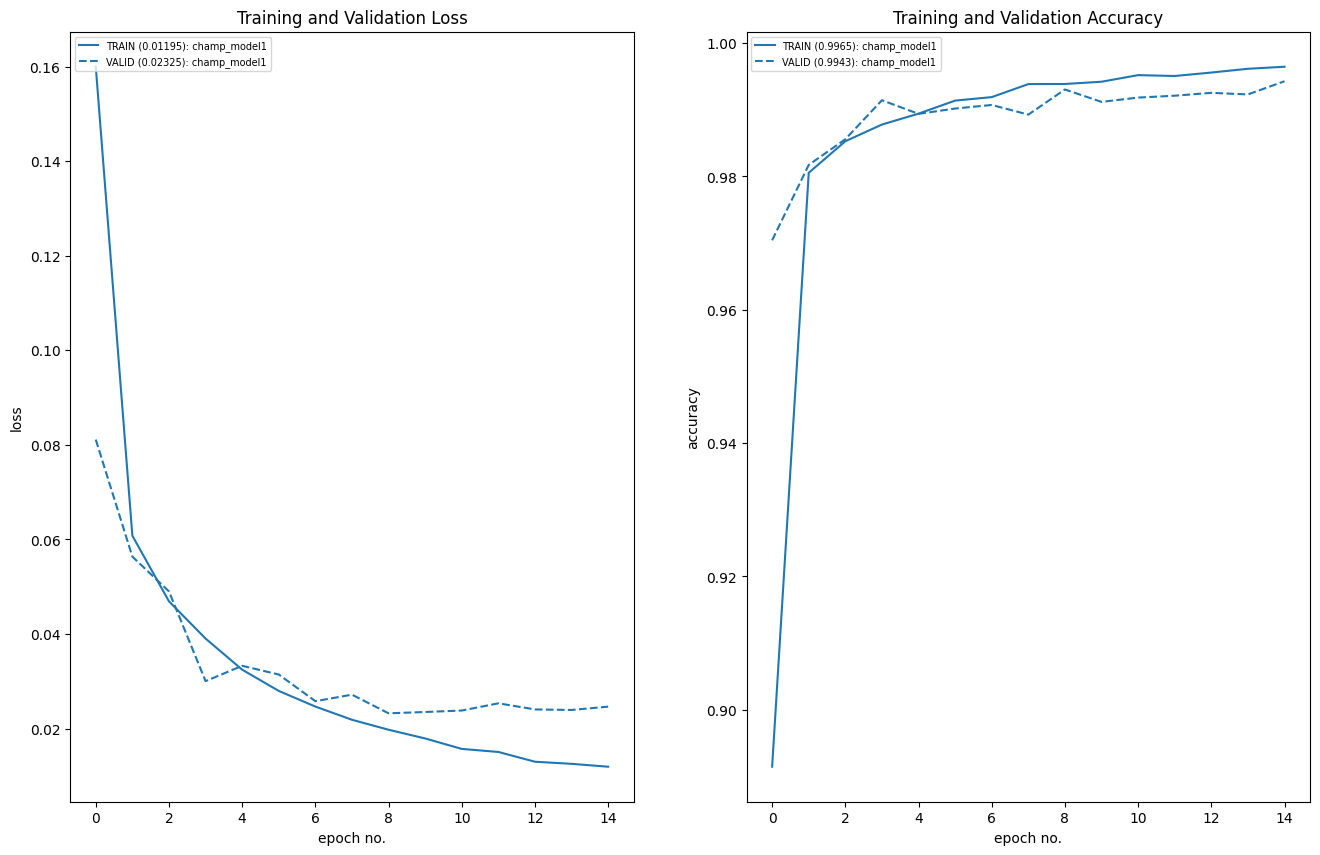

In [29]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['champ_model1'],
                   colors=['blue'],
                   loss_legend_loc='upper left',
                   acc_legend_loc='upper left',
                   legend_font=7)

In [30]:
class Mnist_Champ_Model_FL2(nn.Module):

  def __init__(self, in_channels, hidden_units, out_channels):
    super(Mnist_Champ_Model_FL2, self).__init__()

    # 3 sets of convolution blocks with batchnorm added
    self.conv1 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=in_channels, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #26,3
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        #set-2
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,  kernel_size=3, stride=1, padding=0), #24,5
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
    )

    # transition block with 1,1 mixer and maxpool added after it ie condense and compress
    self.transition = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=1, stride=1, padding=0), #24,6
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2) #12,6
    )

    # 3 sets of convolution blocks with batchnorm added
    self.conv2 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #10,10
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        #set-2
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #8,14
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        #set-3
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #6,18
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),

        # set-4
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #4,22
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),

         # set-4
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #2,26
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),

    )

    self.classifier = nn.Sequential(nn.Conv2d(in_channels=hidden_units, out_channels=out_channels, kernel_size=2, stride=1, padding=0))
    self.dropout = nn.Dropout(p=0.1)


  def forward(self, x):
      x = self.conv1(x)
      x = self.dropout(x)
      x = self.transition(x)
      x = self.conv2(x)
      x = self.dropout(x)
      x = self.classifier(x)
      x = x.view(-1, 10)

      return F.log_softmax(x, dim=-1)

In [31]:
# New Model Instance
champ_model_2 = Mnist_Champ_Model_FL2(in_channels=1, hidden_units=10, out_channels=10).to(device)
summary(champ_model_2, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]             910
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
           Dropout-7           [-1, 10, 24, 24]               0
            Conv2d-8           [-1, 10, 24, 24]             110
       BatchNorm2d-9           [-1, 10, 24, 24]              20
             ReLU-10           [-1, 10, 24, 24]               0
        MaxPool2d-11           [-1, 10, 12, 12]               0
           Conv2d-12           [-1, 10, 10, 10]             910
      BatchNorm2d-13           [-1, 10, 10, 10]              20
             ReLU-14           [-1, 10,

In [32]:
# driver setup----
# optmizer
optimizer = optim.Adam(champ_model_2.parameters(), lr=1e-2)
# loss
criterion = nn.CrossEntropyLoss()
# metric
metric = MulticlassAccuracy(device = device, num_classes=10)
# LR Scheduler - Exponential
lr_scheduler = ExponentialLR(optimizer, gamma = 0.9) # lr_t = lr_t-1 * gamma

In [33]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(champ_model_2, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(champ_model_2, device, test_loader, criterion, metric, test_losses, test_metrics)
  lr_scheduler.step() # lr scheduler stepping
  print(f"For next epoch {lr_scheduler.get_last_lr()[0]}")

Epoch 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Avg Train Loss: 0.22037983296125302 Avg Train Metric: 0.8497392271182684: 100%|██████████| 469/469 [00:26<00:00, 17.74it/s]


Function Took 26.4514 seconds


Avg Test Loss: 0.0731806296772689 Avg Test Metric: 0.976558008525945: 100%|██████████| 79/79 [00:03<00:00, 21.34it/s]


Function Took 3.7086 seconds
For next epoch 0.009000000000000001
Epoch 1


Avg Train Loss: 0.08155895347423009 Avg Train Metric: 0.97444626237792: 100%|██████████| 469/469 [00:21<00:00, 21.62it/s]


Function Took 21.6990 seconds


Avg Test Loss: 0.06096193733141769 Avg Test Metric: 0.9803040261510052: 100%|██████████| 79/79 [00:02<00:00, 29.30it/s]


Function Took 2.7084 seconds
For next epoch 0.008100000000000001
Epoch 2


Avg Train Loss: 0.06288191101162323 Avg Train Metric: 0.9800341959192809: 100%|██████████| 469/469 [00:22<00:00, 20.49it/s]


Function Took 22.8997 seconds


Avg Test Loss: 0.04760924967218049 Avg Test Metric: 0.986864724491216: 100%|██████████| 79/79 [00:02<00:00, 29.56it/s]


Function Took 2.6807 seconds
For next epoch 0.007290000000000001
Epoch 3


Avg Train Loss: 0.05475423646185285 Avg Train Metric: 0.9831850571927231: 100%|██████████| 469/469 [00:27<00:00, 17.01it/s]


Function Took 27.5881 seconds


Avg Test Loss: 0.041478003557960066 Avg Test Metric: 0.984876106056986: 100%|██████████| 79/79 [00:04<00:00, 18.44it/s]


Function Took 4.2994 seconds
For next epoch 0.006561000000000002
Epoch 4


Avg Train Loss: 0.048470279254984344 Avg Train Metric: 0.9850386415463267: 100%|██████████| 469/469 [00:32<00:00, 14.54it/s]


Function Took 32.2739 seconds


Avg Test Loss: 0.039492490475914806 Avg Test Metric: 0.9865992295591137: 100%|██████████| 79/79 [00:04<00:00, 17.95it/s]


Function Took 4.4088 seconds
For next epoch 0.005904900000000002
Epoch 5


Avg Train Loss: 0.042000721311266184 Avg Train Metric: 0.987869298915619: 100%|██████████| 469/469 [00:26<00:00, 17.66it/s]


Function Took 26.5762 seconds


Avg Test Loss: 0.040878414141037794 Avg Test Metric: 0.9874071343035637: 100%|██████████| 79/79 [00:02<00:00, 27.44it/s]


Function Took 2.8880 seconds
For next epoch 0.005314410000000002
Epoch 6


Avg Train Loss: 0.038597482207443704 Avg Train Metric: 0.9881470283465599: 100%|██████████| 469/469 [00:21<00:00, 22.32it/s]


Function Took 21.0168 seconds


Avg Test Loss: 0.034725862511734276 Avg Test Metric: 0.9883398406113251: 100%|██████████| 79/79 [00:03<00:00, 23.86it/s]


Function Took 3.3248 seconds
For next epoch 0.004782969000000002
Epoch 7


Avg Train Loss: 0.03442517907541396 Avg Train Metric: 0.9900005593228696: 100%|██████████| 469/469 [00:22<00:00, 21.11it/s]


Function Took 22.2318 seconds


Avg Test Loss: 0.028145304112547797 Avg Test Metric: 0.9911763849137705: 100%|██████████| 79/79 [00:03<00:00, 23.83it/s]


Function Took 3.3216 seconds
For next epoch 0.004304672100000002
Epoch 8


Avg Train Loss: 0.031957911361735675 Avg Train Metric: 0.9913014350161116: 100%|██████████| 469/469 [00:22<00:00, 20.55it/s]


Function Took 22.8357 seconds


Avg Test Loss: 0.033878373910519705 Avg Test Metric: 0.9875967004631139: 100%|██████████| 79/79 [00:02<00:00, 29.21it/s]


Function Took 2.7146 seconds
For next epoch 0.003874204890000002
Epoch 9


Avg Train Loss: 0.030110765284032566 Avg Train Metric: 0.9916041917892408: 100%|██████████| 469/469 [00:22<00:00, 21.20it/s]


Function Took 22.1284 seconds


Avg Test Loss: 0.029356151649763785 Avg Test Metric: 0.9905929957764058: 100%|██████████| 79/79 [00:03<00:00, 22.50it/s]


Function Took 3.5207 seconds
For next epoch 0.003486784401000002
Epoch 10


Avg Train Loss: 0.027391987742790613 Avg Train Metric: 0.9916746589674879: 100%|██████████| 469/469 [00:21<00:00, 22.00it/s]


Function Took 21.3270 seconds


Avg Test Loss: 0.036283419725390835 Avg Test Metric: 0.9892823085000243: 100%|██████████| 79/79 [00:02<00:00, 27.94it/s]


Function Took 2.8382 seconds
For next epoch 0.003138105960900002
Epoch 11


Avg Train Loss: 0.02494375758865443 Avg Train Metric: 0.9926632391110158: 100%|██████████| 469/469 [00:24<00:00, 18.89it/s]


Function Took 24.8371 seconds


Avg Test Loss: 0.027164475458137737 Avg Test Metric: 0.99110885285124: 100%|██████████| 79/79 [00:03<00:00, 24.69it/s]


Function Took 3.2084 seconds
For next epoch 0.0028242953648100018
Epoch 12


Avg Train Loss: 0.02312095197072046 Avg Train Metric: 0.9937574127589716: 100%|██████████| 469/469 [00:23<00:00, 19.93it/s]


Function Took 23.5357 seconds


Avg Test Loss: 0.026756197573687836 Avg Test Metric: 0.9912176584895653: 100%|██████████| 79/79 [00:02<00:00, 28.39it/s]


Function Took 2.7919 seconds
For next epoch 0.0025418658283290017
Epoch 13


Avg Train Loss: 0.02154635647852927 Avg Train Metric: 0.9930273809158472: 100%|██████████| 469/469 [00:21<00:00, 21.62it/s]


Function Took 21.7044 seconds


Avg Test Loss: 0.026973915813915148 Avg Test Metric: 0.9940886112708079: 100%|██████████| 79/79 [00:03<00:00, 19.78it/s]


Function Took 4.0033 seconds
For next epoch 0.0022876792454961017
Epoch 14


Avg Train Loss: 0.020698578073469392 Avg Train Metric: 0.9940365449960298: 100%|██████████| 469/469 [00:21<00:00, 21.47it/s]


Function Took 21.8578 seconds


Avg Test Loss: 0.03031274847556613 Avg Test Metric: 0.9927541892739791: 100%|██████████| 79/79 [00:02<00:00, 28.59it/s]

Function Took 2.7753 seconds
For next epoch 0.0020589113209464917


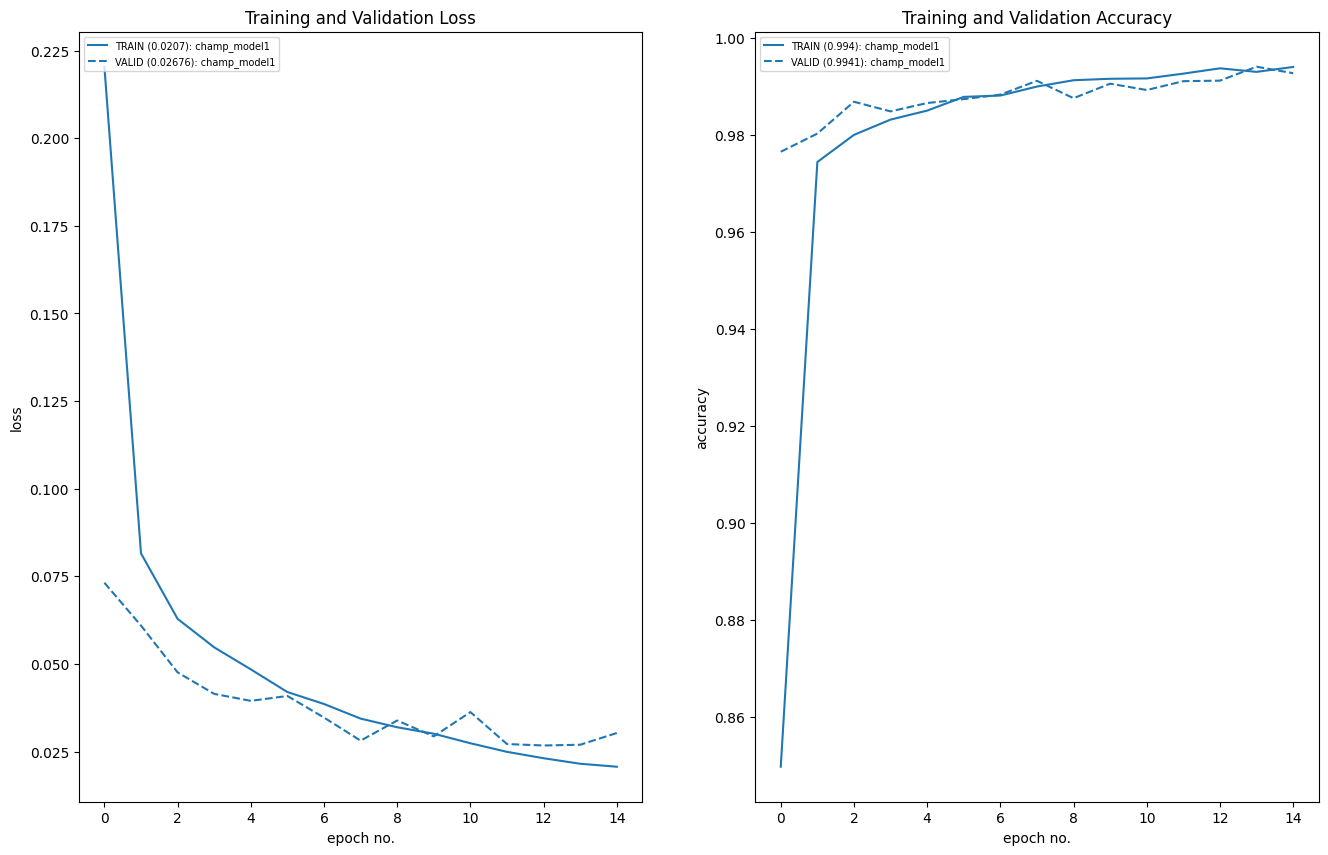

In [34]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['champ_model2'],
                   colors=['blue'],
                   loss_legend_loc='upper left',
                   acc_legend_loc='upper left',
                   legend_font=7)

In [35]:
# New Model Instance
champ_model_2 = Mnist_Champ_Model_FL2(in_channels=1, hidden_units=10, out_channels=10).to(device)
summary(champ_model_2, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]             910
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
           Dropout-7           [-1, 10, 24, 24]               0
            Conv2d-8           [-1, 10, 24, 24]             110
       BatchNorm2d-9           [-1, 10, 24, 24]              20
             ReLU-10           [-1, 10, 24, 24]               0
        MaxPool2d-11           [-1, 10, 12, 12]               0
           Conv2d-12           [-1, 10, 10, 10]             910
      BatchNorm2d-13           [-1, 10, 10, 10]              20
             ReLU-14           [-1, 10,

In [36]:
# driver setup----
# optmizer
optimizer = optim.Adam(champ_model_2.parameters(), lr=1e-2)
# loss
criterion = nn.CrossEntropyLoss()
# metric
metric = MulticlassAccuracy(device = device, num_classes=10)
# LR Scheduler - Exponential
lr_scheduler = ExponentialLR(optimizer, gamma = 0.75) # lr_t = lr_t-1 * gamma

In [37]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(champ_model_2, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(champ_model_2, device, test_loader, criterion, metric, test_losses, test_metrics)
  lr_scheduler.step() # lr scheduler stepping
  print(f"For next epoch {lr_scheduler.get_last_lr()[0]}")

Epoch 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Avg Train Loss: 0.22477646898835707 Avg Train Metric: 0.8556817479288654: 100%|██████████| 469/469 [00:21<00:00, 22.06it/s]


Function Took 21.2662 seconds


Avg Test Loss: 0.09418701352197913 Avg Test Metric: 0.9709102277514301: 100%|██████████| 79/79 [00:03<00:00, 23.17it/s]


Function Took 3.4189 seconds
For next epoch 0.0075
Epoch 1


Avg Train Loss: 0.07386123188443657 Avg Train Metric: 0.9760989954730849: 100%|██████████| 469/469 [00:23<00:00, 20.12it/s]


Function Took 23.3184 seconds


Avg Test Loss: 0.06684906475682141 Avg Test Metric: 0.9791989288752592: 100%|██████████| 79/79 [00:02<00:00, 29.21it/s]


Function Took 2.7148 seconds
For next epoch 0.005625
Epoch 2


Avg Train Loss: 0.05740379174944879 Avg Train Metric: 0.9824127609541675: 100%|██████████| 469/469 [00:22<00:00, 20.65it/s]


Function Took 22.7173 seconds


Avg Test Loss: 0.03899076784654414 Avg Test Metric: 0.9872039005726199: 100%|██████████| 79/79 [00:02<00:00, 29.51it/s]


Function Took 2.6863 seconds
For next epoch 0.00421875
Epoch 3


Avg Train Loss: 0.04736417247605985 Avg Train Metric: 0.9857390416202261: 100%|██████████| 469/469 [00:22<00:00, 21.30it/s]


Function Took 22.0296 seconds


Avg Test Loss: 0.03840037793233472 Avg Test Metric: 0.9888224850727033: 100%|██████████| 79/79 [00:03<00:00, 22.65it/s]


Function Took 3.4985 seconds
For next epoch 0.0031640625
Epoch 4


Avg Train Loss: 0.039777837869431225 Avg Train Metric: 0.9890545440126838: 100%|██████████| 469/469 [00:21<00:00, 22.22it/s]


Function Took 21.1141 seconds


Avg Test Loss: 0.03448376561812703 Avg Test Metric: 0.9910621092289309: 100%|██████████| 79/79 [00:03<00:00, 25.15it/s]


Function Took 3.1499 seconds
For next epoch 0.002373046875
Epoch 5


Avg Train Loss: 0.035471006795497875 Avg Train Metric: 0.9895517726951062: 100%|██████████| 469/469 [00:22<00:00, 21.05it/s]


Function Took 22.2874 seconds


Avg Test Loss: 0.03262562250800997 Avg Test Metric: 0.988541123233264: 100%|██████████| 79/79 [00:02<00:00, 28.67it/s]


Function Took 2.7658 seconds
For next epoch 0.0017797851562500002
Epoch 6


Avg Train Loss: 0.029331396503904178 Avg Train Metric: 0.9912597806468956: 100%|██████████| 469/469 [00:23<00:00, 20.22it/s]


Function Took 23.1976 seconds


Avg Test Loss: 0.03392964257870482 Avg Test Metric: 0.9912977980661996: 100%|██████████| 79/79 [00:02<00:00, 27.81it/s]


Function Took 2.8509 seconds
For next epoch 0.0013348388671875003
Epoch 7


Avg Train Loss: 0.02659740421210112 Avg Train Metric: 0.9915411371920408: 100%|██████████| 469/469 [00:23<00:00, 20.32it/s]


Function Took 23.0992 seconds


Avg Test Loss: 0.02752831490132722 Avg Test Metric: 0.9932192239580275: 100%|██████████| 79/79 [00:03<00:00, 20.16it/s]


Function Took 3.9264 seconds
For next epoch 0.0010011291503906252
Epoch 8


Avg Train Loss: 0.02554500898269853 Avg Train Metric: 0.992347242989774: 100%|██████████| 469/469 [00:21<00:00, 22.11it/s]


Function Took 21.2180 seconds


Avg Test Loss: 0.027238717662241264 Avg Test Metric: 0.9925222698646256: 100%|██████████| 79/79 [00:02<00:00, 29.61it/s]


Function Took 2.6774 seconds
For next epoch 0.0007508468627929689
Epoch 9


Avg Train Loss: 0.023000218984690794 Avg Train Metric: 0.9925565171851787: 100%|██████████| 469/469 [00:22<00:00, 20.57it/s]


Function Took 22.8101 seconds


Avg Test Loss: 0.02595313646479899 Avg Test Metric: 0.9931767597983155: 100%|██████████| 79/79 [00:02<00:00, 29.47it/s]


Function Took 2.6893 seconds
For next epoch 0.0005631351470947267
Epoch 10


Avg Train Loss: 0.02282093737365257 Avg Train Metric: 0.99298782096997: 100%|██████████| 469/469 [00:22<00:00, 20.91it/s]


Function Took 22.4339 seconds


Avg Test Loss: 0.030546638298237436 Avg Test Metric: 0.9916410974309414: 100%|██████████| 79/79 [00:02<00:00, 27.76it/s]


Function Took 2.8524 seconds
For next epoch 0.000422351360321045
Epoch 11


Avg Train Loss: 0.019950429247175928 Avg Train Metric: 0.9935838235720896: 100%|██████████| 469/469 [00:21<00:00, 21.70it/s]


Function Took 21.6247 seconds


Avg Test Loss: 0.02604796192159322 Avg Test Metric: 0.9916156832175919: 100%|██████████| 79/79 [00:03<00:00, 21.18it/s]


Function Took 3.7397 seconds
For next epoch 0.00031676352024078374
Epoch 12


Avg Train Loss: 0.019648845514172373 Avg Train Metric: 0.9943038370055176: 100%|██████████| 469/469 [00:21<00:00, 21.53it/s]


Function Took 21.7896 seconds


Avg Test Loss: 0.02441210121054886 Avg Test Metric: 0.9934041688713846: 100%|██████████| 79/79 [00:02<00:00, 28.67it/s]


Function Took 2.7652 seconds
For next epoch 0.00023757264018058782
Epoch 13


Avg Train Loss: 0.019509296259730618 Avg Train Metric: 0.9943543597579256: 100%|██████████| 469/469 [00:22<00:00, 20.61it/s]


Function Took 22.7701 seconds


Avg Test Loss: 0.02514991939290356 Avg Test Metric: 0.9924513463732563: 100%|██████████| 79/79 [00:02<00:00, 29.16it/s]


Function Took 2.7235 seconds
For next epoch 0.00017817948013544086
Epoch 14


Avg Train Loss: 0.017562624810115574 Avg Train Metric: 0.9948653247056485: 100%|██████████| 469/469 [00:23<00:00, 19.80it/s]


Function Took 23.6967 seconds


Avg Test Loss: 0.02624902847264245 Avg Test Metric: 0.9932270276395581: 100%|██████████| 79/79 [00:03<00:00, 22.57it/s]

Function Took 3.5061 seconds
For next epoch 0.00013363461010158065


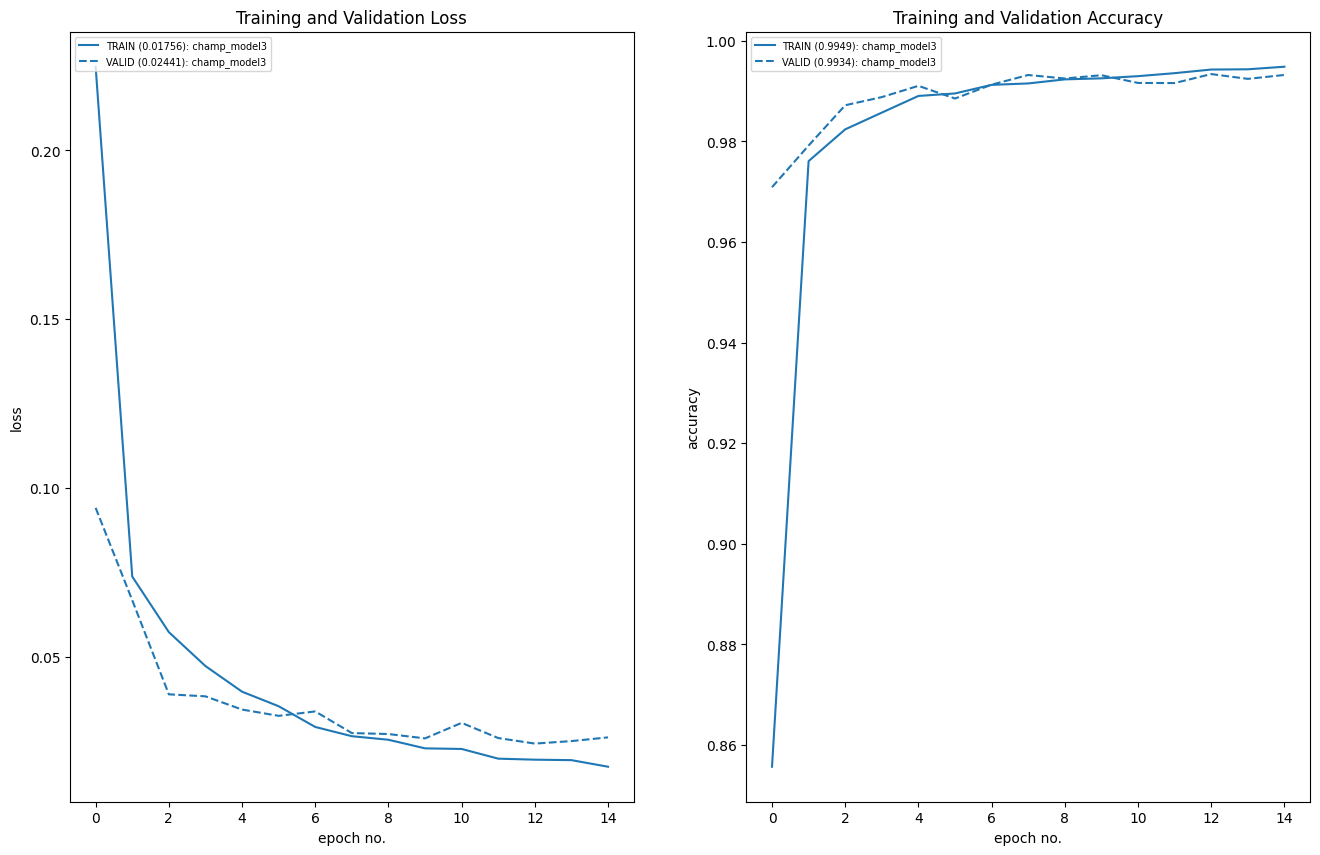

In [38]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['champ_model3'],
                   colors=['blue'],
                   loss_legend_loc='upper left',
                   acc_legend_loc='upper left',
                   legend_font=7)

In [ ]:
# adding DropOuts within layers

In [41]:
class Mnist_Champ_Model_FL3(nn.Module):

  def __init__(self, in_channels, hidden_units, out_channels):
    super(Mnist_Champ_Model_FL3, self).__init__()

    # 3 sets of convolution blocks with batchnorm added
    self.conv1 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=in_channels, out_channels=hidden_units*2, kernel_size=3, stride=1, padding=0), #26,3
        nn.BatchNorm2d(hidden_units*2),
        nn.ReLU(),
        #set-2
        nn.Conv2d(in_channels=hidden_units*2, out_channels=hidden_units,  kernel_size=3, stride=1, padding=0), #24,5
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),

    )

    # transition block with 1,1 mixer and maxpool added after it ie condense and compress
    self.transition = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=1, stride=1, padding=0), #24,6
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2) #12,6
    )

    # 3 sets of convolution blocks with batchnorm added
    self.conv2 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units*2, kernel_size=3, stride=1, padding=0), #10,10
        nn.BatchNorm2d(hidden_units*2),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        #set-2
        nn.Conv2d(in_channels=hidden_units*2, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #8,14
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        #set-3
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #6,18
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        # set-4
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #4,22
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),

    )

    self.classifier = nn.Sequential(nn.Conv2d(in_channels=hidden_units, out_channels=out_channels, kernel_size=4, stride=1, padding=0)) # 7*7 kernel as classifier


  def forward(self, x):
      x = self.conv1(x)
      x = self.transition(x)
      x = self.conv2(x)
      x = self.classifier(x)
      x = x.view(-1, 10)

      return F.log_softmax(x, dim=-1)

In [42]:
# New Model Instance
champ_model4 = Mnist_Champ_Model_FL3(in_channels=1,hidden_units=10,out_channels=10).to(device)
summary(champ_model4, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 26, 26]             200
       BatchNorm2d-2           [-1, 20, 26, 26]              40
              ReLU-3           [-1, 20, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]           1,810
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
           Dropout-7           [-1, 10, 24, 24]               0
            Conv2d-8           [-1, 10, 24, 24]             110
       BatchNorm2d-9           [-1, 10, 24, 24]              20
             ReLU-10           [-1, 10, 24, 24]               0
        MaxPool2d-11           [-1, 10, 12, 12]               0
           Conv2d-12           [-1, 20, 10, 10]           1,820
      BatchNorm2d-13           [-1, 20, 10, 10]              40
             ReLU-14           [-1, 20,

In [43]:
# driver setup----
# optmizer
optimizer = optim.Adam(champ_model4.parameters(), lr=1e-2)
# loss
criterion = nn.CrossEntropyLoss()
# metric
metric = MulticlassAccuracy(device = device, num_classes=10)
# LR Scheduler - Exponential
lr_scheduler = ExponentialLR(optimizer, gamma = 0.83) # lr_t = lr_t-1 * gamma

In [44]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(champ_model4, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(champ_model4, device, test_loader, criterion, metric, test_losses, test_metrics)
  lr_scheduler.step() # lr scheduler stepping
  print(f"For next epoch {lr_scheduler.get_last_lr()[0]}")

Epoch 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Avg Train Loss: 0.17848329734343138 Avg Train Metric: 0.880158361627349: 100%|██████████| 469/469 [00:22<00:00, 21.18it/s]


Function Took 22.1522 seconds


Avg Test Loss: 0.05395261426986773 Avg Test Metric: 0.9837857054758675: 100%|██████████| 79/79 [00:02<00:00, 28.59it/s]


Function Took 2.7695 seconds
For next epoch 0.0083
Epoch 1


Avg Train Loss: 0.0742340541101182 Avg Train Metric: 0.9763179722625309: 100%|██████████| 469/469 [00:22<00:00, 20.63it/s]


Function Took 22.7449 seconds


Avg Test Loss: 0.04182512914729482 Avg Test Metric: 0.9845647977877267: 100%|██████████| 79/79 [00:02<00:00, 28.71it/s]


Function Took 2.7592 seconds
For next epoch 0.006889
Epoch 2


Avg Train Loss: 0.05752496919167766 Avg Train Metric: 0.9810401310544532: 100%|██████████| 469/469 [00:21<00:00, 21.88it/s]


Function Took 21.4458 seconds


Avg Test Loss: 0.036069910967416026 Avg Test Metric: 0.9905887661100943: 100%|██████████| 79/79 [00:03<00:00, 21.00it/s]


Function Took 3.7671 seconds
For next epoch 0.00571787
Epoch 3


Avg Train Loss: 0.05002346887155922 Avg Train Metric: 0.9854559942857543: 100%|██████████| 469/469 [00:21<00:00, 21.63it/s]


Function Took 21.7018 seconds


Avg Test Loss: 0.03620528551172229 Avg Test Metric: 0.9888461986674538: 100%|██████████| 79/79 [00:03<00:00, 25.07it/s]


Function Took 3.1643 seconds
For next epoch 0.0047458321
Epoch 4


Avg Train Loss: 0.044020653090207404 Avg Train Metric: 0.9857690688897806: 100%|██████████| 469/469 [00:24<00:00, 19.38it/s]


Function Took 24.2045 seconds


Avg Test Loss: 0.030008700390381716 Avg Test Metric: 0.9915315508842468: 100%|██████████| 79/79 [00:02<00:00, 28.87it/s]


Function Took 2.7453 seconds
For next epoch 0.003939040643
Epoch 5


Avg Train Loss: 0.039761873422317635 Avg Train Metric: 0.9876106355998562: 100%|██████████| 469/469 [00:22<00:00, 20.73it/s]


Function Took 22.6378 seconds


Avg Test Loss: 0.028044664043832948 Avg Test Metric: 0.9928324516815475: 100%|██████████| 79/79 [00:02<00:00, 28.83it/s]


Function Took 2.7487 seconds
For next epoch 0.00326940373369
Epoch 6


Avg Train Loss: 0.03705515472718807 Avg Train Metric: 0.9887580356872412: 100%|██████████| 469/469 [00:21<00:00, 21.54it/s]


Function Took 21.7888 seconds


Avg Test Loss: 0.025700690711058582 Avg Test Metric: 0.9923656099959265: 100%|██████████| 79/79 [00:03<00:00, 20.87it/s]


Function Took 3.7956 seconds
For next epoch 0.0027136050989627
Epoch 7


Avg Train Loss: 0.033893421719988576 Avg Train Metric: 0.9899721205361617: 100%|██████████| 469/469 [00:21<00:00, 21.68it/s]


Function Took 21.6376 seconds


Avg Test Loss: 0.024929207290266344 Avg Test Metric: 0.9929471921317184: 100%|██████████| 79/79 [00:03<00:00, 25.34it/s]


Function Took 3.1279 seconds
For next epoch 0.002252292232139041
Epoch 8


Avg Train Loss: 0.03197728576541229 Avg Train Metric: 0.9899492472219569: 100%|██████████| 469/469 [00:22<00:00, 20.72it/s]


Function Took 22.6381 seconds


Avg Test Loss: 0.02856969421499562 Avg Test Metric: 0.991835926906972: 100%|██████████| 79/79 [00:02<00:00, 28.26it/s]


Function Took 2.8054 seconds
For next epoch 0.001869402552675404
Epoch 9


Avg Train Loss: 0.029733191282033666 Avg Train Metric: 0.9917937580710535: 100%|██████████| 469/469 [00:22<00:00, 20.43it/s]


Function Took 22.9665 seconds


Avg Test Loss: 0.023974614281979497 Avg Test Metric: 0.9939896871771994: 100%|██████████| 79/79 [00:02<00:00, 28.81it/s]


Function Took 2.7533 seconds
For next epoch 0.0015516041187205853
Epoch 10


Avg Train Loss: 0.0281874354961497 Avg Train Metric: 0.991249772785569: 100%|██████████| 469/469 [00:23<00:00, 19.67it/s]


Function Took 23.8481 seconds


Avg Test Loss: 0.023687603307263102 Avg Test Metric: 0.9921523981456515: 100%|██████████| 79/79 [00:03<00:00, 21.28it/s]


Function Took 3.7204 seconds
For next epoch 0.0012878314185380856
Epoch 11


Avg Train Loss: 0.02601314112328108 Avg Train Metric: 0.9915651586264181: 100%|██████████| 469/469 [00:21<00:00, 21.62it/s]


Function Took 21.7022 seconds


Avg Test Loss: 0.024285767444032186 Avg Test Metric: 0.9926830492442167: 100%|██████████| 79/79 [00:03<00:00, 24.54it/s]


Function Took 3.2341 seconds
For next epoch 0.001068900077386611
Epoch 12


Avg Train Loss: 0.025676671125149646 Avg Train Metric: 0.9920851110395338: 100%|██████████| 469/469 [00:22<00:00, 21.14it/s]


Function Took 22.1959 seconds


Avg Test Loss: 0.022755426210292345 Avg Test Metric: 0.9947131653375263: 100%|██████████| 79/79 [00:02<00:00, 28.42it/s]


Function Took 2.7922 seconds
For next epoch 0.0008871870642308871
Epoch 13


Avg Train Loss: 0.025409329258876522 Avg Train Metric: 0.991888825827316: 100%|██████████| 469/469 [00:23<00:00, 20.35it/s]


Function Took 23.0532 seconds


Avg Test Loss: 0.020936200504273743 Avg Test Metric: 0.9926616904101794: 100%|██████████| 79/79 [00:02<00:00, 28.44it/s]


Function Took 2.7879 seconds
For next epoch 0.0007363652633116363
Epoch 14


Avg Train Loss: 0.023467516273767478 Avg Train Metric: 0.9930942446184057: 100%|██████████| 469/469 [00:22<00:00, 20.75it/s]


Function Took 22.6168 seconds


Avg Test Loss: 0.022190513158190546 Avg Test Metric: 0.9934907683843299: 100%|██████████| 79/79 [00:03<00:00, 23.67it/s]

Function Took 3.3480 seconds
For next epoch 0.0006111831685486581


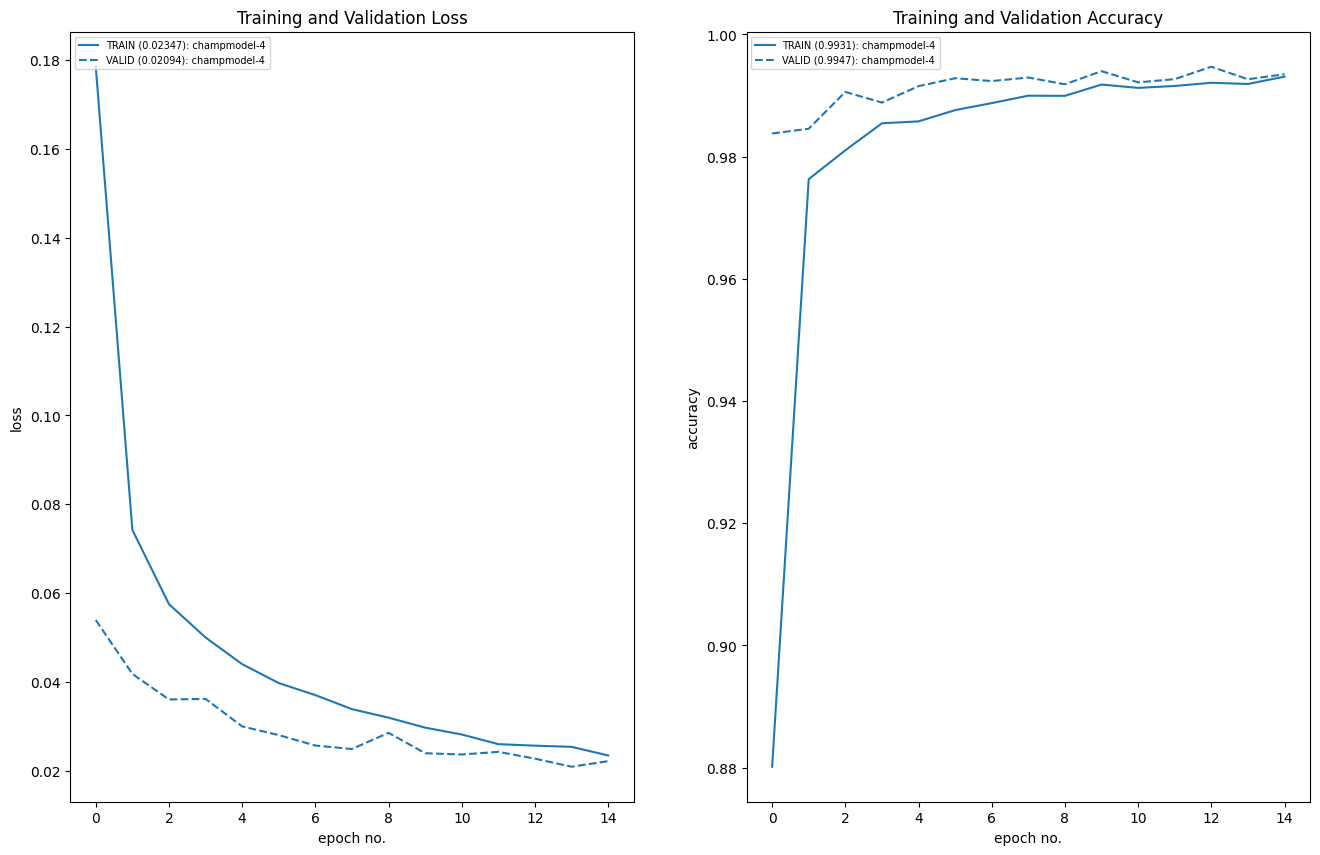

In [45]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['champmodel-4'],
                   colors=['blue'],
                   loss_legend_loc='upper left',
                   acc_legend_loc='upper left',
                   legend_font=7)

Target:

1.Improve the baseline model with dropout added after every transitioin block
2.Improve the expanded model ie model with more kernels and more layers with dropout added
3.Improve the model LR scheduler

Results:\
Parameters: 6k-9k\
Best Training Accuracy: 99.3-99.5\
Best Test Accuracy: 99.3-99.5

Analysis:
1. Model with under 8k params are good but fluctuating
2. Add a bit more kernels helps in attaining stabality
3. LR needs to be palyed around for improving performance